Pornhub is the third most popular porn site, according to Alexa. About a month ago, I was curious as to some basic statistics about the site, so I scraped it, gathering some data for every video (about 144,000 videos in total). The analysis appears below.

To get started, we need to load up the libraries that we'll be using.

In [1]:
library(dplyr);           ## primary data manipulation tool
library(magrittr);        ## just to get the convenient %<>% operator
library(ggplot2);         ## pretty graphs
library(scales);          ## pretty formatting for graphs
library(gridExtra);       ## plotting multiple graphs at once
library(lubridate);       ## handle dates easier
library(data.table);      ## really just needed for a single operation
library(wordcloud);       ## make pretty wordclouds
library(tidyr);           ## organize data


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:lubridate':

    hour, mday, month, quarter, wday, week, yday, year

The following objects are masked from 'package:dplyr':

    between, last

Loading required package: RColorBrewer
Warning message:
: package 'RColorBrewer' was built under R version 3.2.0Warning message:
: package 'tidyr' was built under R version 3.2.0
Attaching package: 'tidyr'

The following object is masked from 'package:magrittr':

    extract



The data was scraped separately in Python, and written as a large amount of csvs (100 videos per csv). So we need to assemble them into a single dataframe.

In [2]:
pcsvs <- list.files("C:/Users/ben/Desktop/pcsvs/new", full.names = T)
my_files <- lapply(pcsvs, read.csv, stringsAsFactors = F)
phub <- rbind_all(my_files)

## how many videos were there total?

nrow(phub)

## let's take a look at our data

head(phub)

[1] 144175

,URL,count,added,submitter,pornstars,title,percent,votes_down,tags,production,duration,votes_up,categories
1,[u'/view_video.php?viewkey=1338799361'],393252,3 years ago,18 Stream,[],Lovely amateur teen gets fucked hard,79,84,"['18stream.com', 'blowjob', 'amateur', 'redhead', 'shower', 'small-tits', 'homemade', 'teenager']",professional,'8:18,332,"['Amateur', 'Teen', 'Small Tits']"
2,[u'/view_video.php?viewkey=441793069'],226730,3 years ago,Unknown,[],Me_and_my_horny_friends,88,28,"['me', 'my', 'horny', 'friends', 'big-tits', 'threesome', 'dp', 'anal', 'hardcore']",professional,'13:33,208,"['Hardcore', 'Threesome', 'Double Penetration']"
3,[u'/view_video.php?viewkey=1976700368'],1088167,3 years ago,Unknown,['Teddi Holland\t\t\t'],Ass Delivery,86,185,"['small-tits', 'booty', 'butt', 'big-ass', 'pawg', 'phat', 'white', 'oil', 'blowjob', 'pussy-fucking', 'blonde', 'babe']",professional,'43:33,1153,"['Big Ass', 'Babe', 'Hardcore', 'Pornstar']"
4,[u'/view_video.php?viewkey=426730861'],1357146,3 years ago,Smack My Bitch,[],Blonde teen and boyfriend,76,558,"['smackmybitch.com', 'blonde', 'teen', 'rough', 'amateur', 'ass', 'anal', 'homemade', 'ass-fuck', 'small-tits', 'couple', 'teenager', 'ass-fucking', 'teens', 'gaping']",professional,'6:00,1789,"['Amateur', 'Anal', 'Teen']"
5,[u'/view_video.php?viewkey=1154839980'],236823,3 years ago,My Bros GF,[],GF cheats with his BF's bro and gets busted,73,51,"['mybrosgf.com', 'brunette', 'gf', 'girlfriend', 'cheating', 'amateur', 'teen', 'young', 'brother', 'small-tits', 'hardcore', 'fuck', 'euro', 'petite', 'blowjob']",professional,"'],",138,"['Amateur', 'Teen', 'Euro']"
6,[u'/view_video.php?viewkey=645128259'],105776,3 years ago,Wet and Puffy,[],German pussy model,67,24,"['wetandpuffy.com', 'homemade', 'babes', 'teenager', 'fingering', 'brunette', 'camel-toe', 'pussy-eating']",professional,'6:02,49,"['Amateur', 'Brunette', 'Teen']"


Note, most of the columns are obvious, but for `URL`, the URL to the video would be constructed by typing www.pornhub.com and then adding the given URL (minus the fluff added from the scraping process). 

`count` is the number of times the video has been views.

`percent` is the ratio of positive votes to total votes.

`production` is whether or not the video was homemade or professional.

`duration` is length of the video.

`tags` are various things that describe what happens in the video, or what a major theme of the video is.

As we can see, the data is a little messy, and needs to be cleaned up. First we'll address the dates.

In [3]:
unique(phub$added)

[1] "3 years ago"   "3 months ago"  ""              "4 years ago"  
 [5] "1 week ago"    "5 years ago"   "6 years ago"   "4 months ago" 
 [9] "7 years ago"   "2 weeks ago"   "5 months ago"  "6 months ago" 
[13] "Yesterday"     "2 days ago"    "7 months ago"  "3 weeks ago"  
[17] "8 months ago"  "9 months ago"  "3 days ago"    "1 month ago"  
[21] "10 months ago" "11 months ago" "1 year ago"    "4 days ago"   
[25] "5 days ago"    "2 months ago"  "2 years ago"   "6 days ago"   
[29] "9 hours ago"   "18 hours ago"  "20 hours ago"  "11 hours ago" 
[33] "15 hours ago"  "6 hours ago"   "14 hours ago"  "12 hours ago" 
[37] "19 hours ago"  "5 hours ago"   "7 hours ago"   "13 hours ago" 
[41] "4 hours ago"   "17 hours ago"  "8 hours ago"   "10 hours ago" 
[45] "16 hours ago"  "22 hours ago"

Pornhub, unfortunately, doesn't do timestamps for the dates. Instead, if a given video was added recently, the note may say "2 weeks ago", or longer, "3 years ago". Therefore, to be consistent, the best we  can do is get it down to a year level.

Note there are some missing values. How many are there?

In [4]:
sum(phub$added == '')

[1] 92

92 videos out of 144,175 isn't bad. A spot check on some of these shows they're videos that have been pulled for copyright violations.

We'll manipulate the data to get the "x years ago" format for all the data.

In [5]:
## split the dates into components (e.g. ["3", "years", "ago"])
added_list <- strsplit(phub$added, ' ')
## get the raw number part
number <- character(length(added_list))
## get the period part (e.g. 'week')
time_frame <- character(length(added_list))
## make a new list of relevant data (number and period)
for(i in 1:length(added_list)){
  number[i] <- added_list[[i]][1]
  time_frame[i] <- added_list[[i]][2]
}
## we need a reference copy of the number vector
number_copy <- number
## for missing values, we'll say they occurred 100 years ago
number[is.na(number_copy)] <- 100
time_frame[is.na(number_copy)] <- 'year'
## most of the time, the data has 3 elements, but if it says 'yesterday', then it's just the one
## therefore we'll change that to '1 day ago'
number[number_copy == 'Yesterday'] <- 1
time_frame[number_copy == 'Yesterday'] <- 'days'
## we'll pick off the first letter in the period to find out what timeframe it is
time_f <- substr(time_frame, 1, 1)
number <- as.numeric(number)
## use nested ifelses to get the year the video was added
time <- ifelse(time_f == 'm', year(today() - months(number)), 
               ifelse(time_f == 'w', year(today() - weeks(number)),
                      ifelse(time_f == 'y', year(today() - years(number)),
                             ifelse(time_f == 'd', year(today() - days(number)),
                                    year(today() - hours(number))))))
## finally, assign the year to the dataframe as "year"
phub$year <- time
unique(phub$year)


[1] 2012 2015 1915 2011 2010 2009 2008 2014 2013

The dates are now useful to us, but as we can see above the data is otherwise fairly messy. Entries with multiple values (e.g. tags) are written to a single cell with brackets and quotes, and the durations were also a bit wonky, so we'll use some regular expressions to clean them up.

In [6]:
phub %<>%
  mutate(URL = gsub(".*=|']$", "", URL), 
         pornstars = gsub("\\[|\\'|\\]|\\\\t", "", pornstars), 
         tags = gsub("\\[|\\]|\\'", "", tags), 
         categories = gsub("\\[|\\]|\\'", "", categories), 
         duration = gsub("(\\d+:\\d+)(*SKIP)(*F)|.", '', duration, perl=TRUE), 
         submitter = gsub("\\t", "", submitter))

## a bit of research later led to the  discover of a single date that didn't fit the proper format

phub %<>%
  mutate(duration = ifelse(URL == '756790494', '10:00', duration))

head(phub)

,URL,count,added,submitter,pornstars,title,percent,votes_down,tags,production,duration,votes_up,categories,year
1,1338799361,393252,3 years ago,18 Stream,,Lovely amateur teen gets fucked hard,79,84,"18stream.com, blowjob, amateur, redhead, shower, small-tits, homemade, teenager",professional,8:18,332,"Amateur, Teen, Small Tits",2012
2,441793069,226730,3 years ago,Unknown,,Me_and_my_horny_friends,88,28,"me, my, horny, friends, big-tits, threesome, dp, anal, hardcore",professional,13:33,208,"Hardcore, Threesome, Double Penetration",2012
3,1976700368,1088167,3 years ago,Unknown,Teddi Holland,Ass Delivery,86,185,"small-tits, booty, butt, big-ass, pawg, phat, white, oil, blowjob, pussy-fucking, blonde, babe",professional,43:33,1153,"Big Ass, Babe, Hardcore, Pornstar",2012
4,426730861,1357146,3 years ago,Smack My Bitch,,Blonde teen and boyfriend,76,558,"smackmybitch.com, blonde, teen, rough, amateur, ass, anal, homemade, ass-fuck, small-tits, couple, teenager, ass-fucking, teens, gaping",professional,6:00,1789,"Amateur, Anal, Teen",2012
5,1154839980,236823,3 years ago,My Bros GF,,GF cheats with his BF's bro and gets busted,73,51,"mybrosgf.com, brunette, gf, girlfriend, cheating, amateur, teen, young, brother, small-tits, hardcore, fuck, euro, petite, blowjob",professional,,138,"Amateur, Teen, Euro",2012
6,645128259,105776,3 years ago,Wet and Puffy,,German pussy model,67,24,"wetandpuffy.com, homemade, babes, teenager, fingering, brunette, camel-toe, pussy-eating",professional,6:02,49,"Amateur, Brunette, Teen",2012


So our data is for the most part clean right now. We can get a quick idea of how many videos there were per year.

In [7]:
table(phub$year)


 1915  2008  2009  2010  2011  2012  2013  2014  2015 
   92 12913 10101  9030  8779 18218 21377 36610 27055 

We'll ditch the uninformative missing videos and do a visual representation.

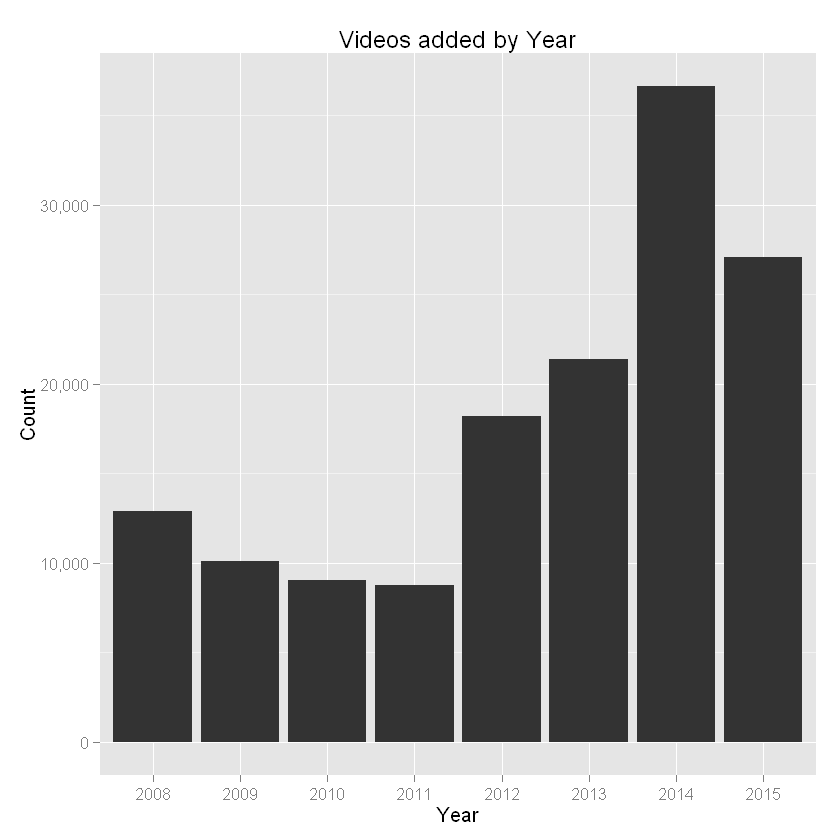

In [8]:
phub_2 <- phub %>% 
  filter(year != 1915)

year_plot <- ggplot(data = phub_2, aes(as.factor(year))) + 
  geom_bar() +
  labs(x = "Year", y = "Count", title = "Videos added by Year") +
  scale_y_continuous(labels = comma)
year_plot

2014 was a good year for porn. Data was collected around 8/01/2015, so about 2/3 of the way through the year.

One of the features available to us was the production of the video (professional or homemade).

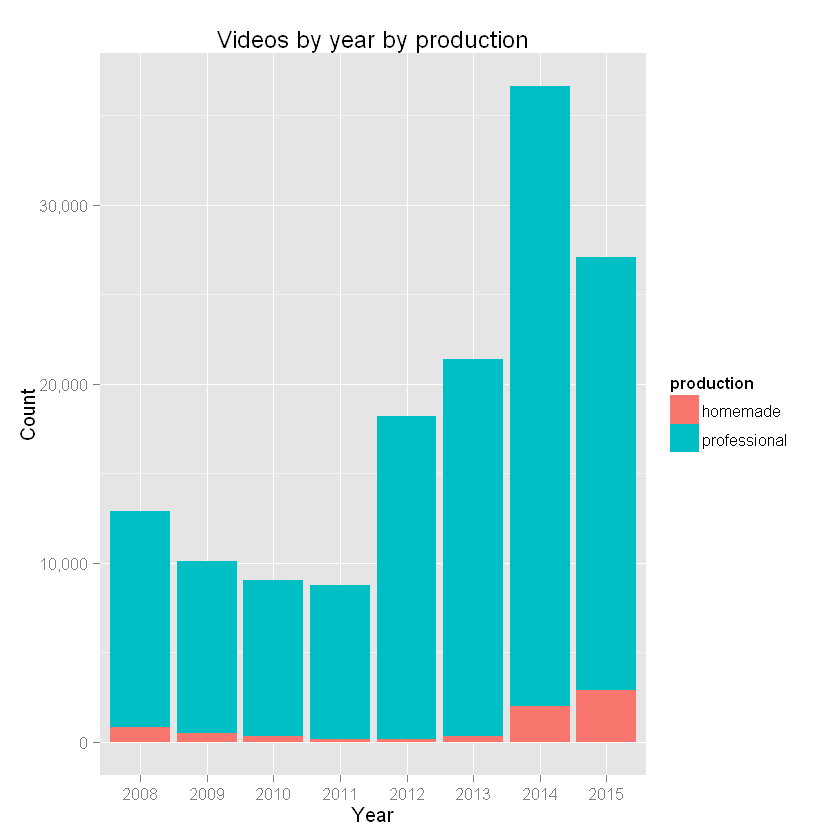

In [9]:
production_plot <- ggplot(data = phub_2, aes(as.factor(year), fill = production)) +
  geom_bar() +
  labs(x = "Year", y = "Count", title = "Videos by year by production") +
  scale_y_continuous(labels = comma)
production_plot

So the vast majority were professional productions.

Another feature available was the rating of the video. How did years fare for average ratings?

,year,avg_ratings
1,2008,82.02687
2,2009,83.8907
3,2010,82.77209
4,2011,80.94305
5,2012,79.08118
6,2013,80.57983
7,2014,77.68801
8,2015,73.51347


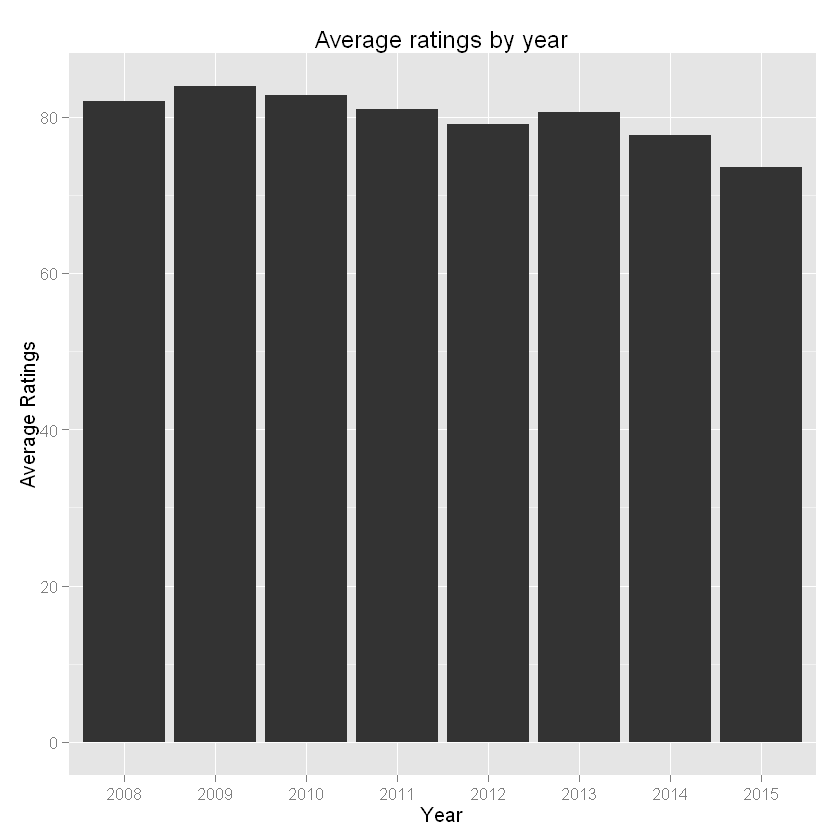

In [10]:
average_ratings <- phub_2 %>% 
  group_by(year) %>% 
  summarise(avg_ratings = mean(percent))
average_ratings

ratings_plot <- ggplot(average_ratings, aes(as.factor(year), avg_ratings)) +
  geom_bar(stat = 'identity') +
  labs(x = "Year", y = "Average Ratings", title = "Average ratings by year")
ratings_plot

Ratings have been more or less consistent, dipping slightly, but still, from a high in 2009 with an average rating of 83 down to 73 in 2015 is a fairly large drop.

We can split the data by production and see if professional videos get higher ratings than homemade videos.

,year,homemade,professional,difference
1,2008,80.18859,82.14925,1.960667
2,2009,79.56375,84.11699,4.553246
3,2010,78.77299,82.93239,4.1594
4,2011,77.62722,81.00813,3.380911
5,2012,75.54777,79.1119,3.564128
6,2013,75.40227,80.66676,5.264496
7,2014,75.99801,77.78629,1.788276
8,2015,74.32708,73.41666,-0.910417


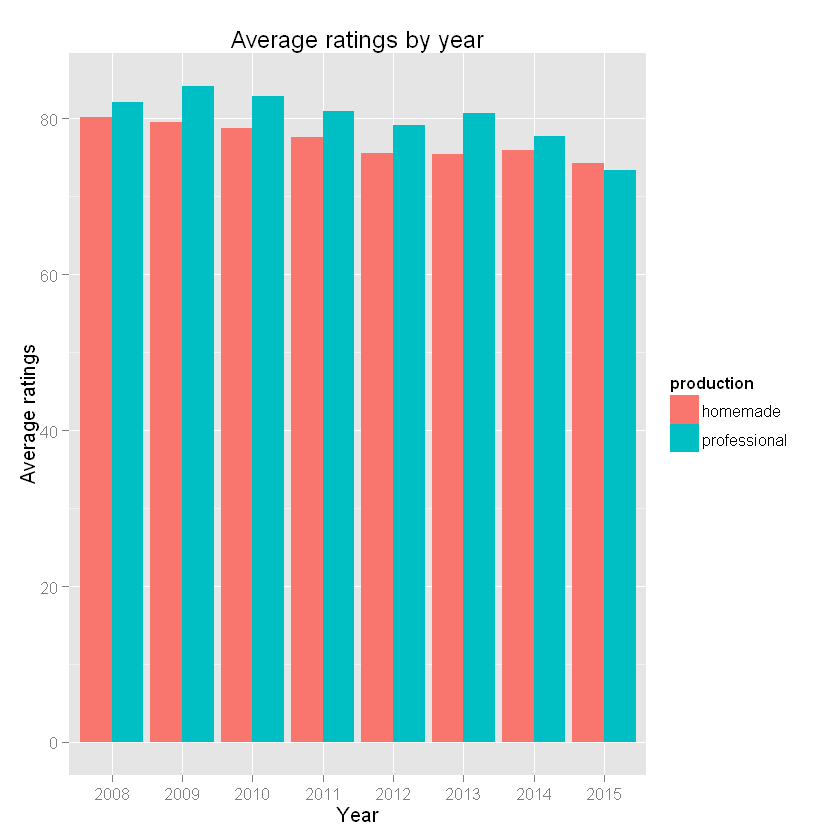

In [11]:
average_ratings_2 <- phub_2 %>% 
  group_by(year, production) %>% 
  summarise(avg_ratings = mean(percent))

average_ratings_2  %>% 
  spread(key = production, value = avg_ratings) %>%
  mutate(difference = professional - homemade)

ratings_2_plot <- ggplot(average_ratings_2, aes(as.factor(year), avg_ratings, fill = production)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  labs(x = "Year", y = "Average ratings", title = "Average ratings by year")
ratings_2_plot

Professional ranks slightly higher than homemade pretty consistently except for 2015 (where the difference is probably neglible).

Another feature available was `count`, which is how many times a video was watched. Note the the data is 'current' which means the data was up to date when the scraping process began. Therefore, when looking at things like years, we're not looking at how many times a video from 2008 was watching IN 2008, but how many times it's been watched since it first appeared.

Anyway, we can look at how many total viewings a video had, the least number of times a video was views, average, and max.

,year,total_views,ave_viewings,min_viewings,max_viewings
1,2008,5445135604,421678.6,9898,46825690
2,2009,10015262780,991512,18152,40487946
3,2010,7057832611,781598.3,25384,47472961
4,2011,6463297221,736222.5,5947,120070966
5,2012,9306221304,510825.6,15869,36938644
6,2013,9293637298,434749.4,3687,36565623
7,2014,11226307486,306645.9,1323,20017570
8,2015,11980141026,442806.9,3751,43022725


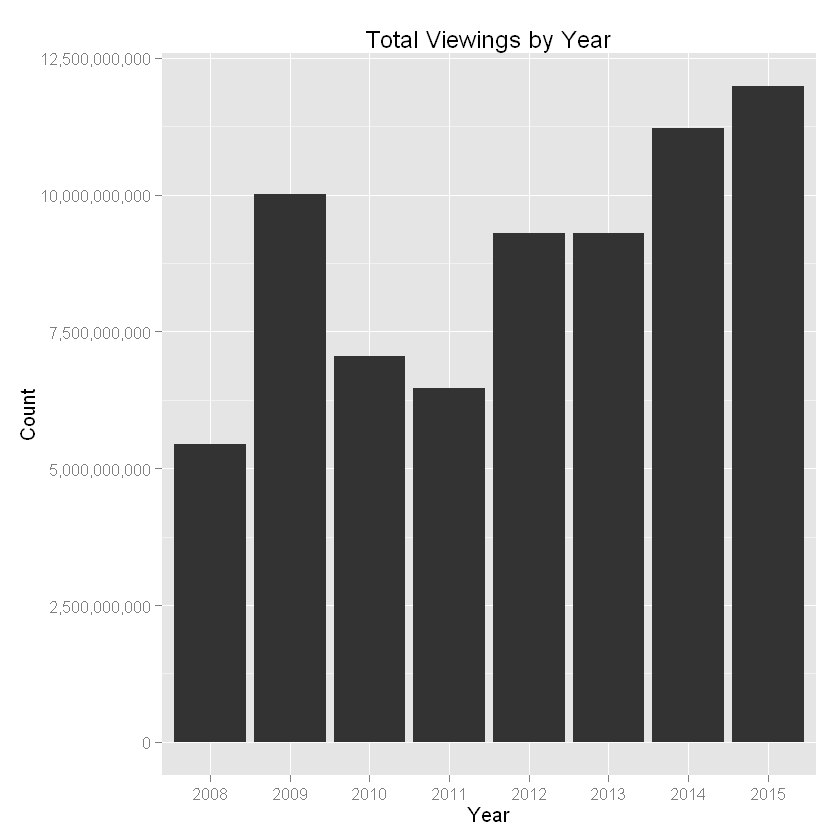

In [12]:
viewings <- phub_2 %>% 
  group_by(year) %>% 
  summarise(total_views = sum(as.numeric(count)), ave_viewings = mean(count), 
            min_viewings = min(count), max_viewings = max(count))
viewings

total_viewings_plot <- ggplot(data = viewings, aes(as.factor(year), total_views)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Year', y = 'Count', title = 'Total Viewings by Year') +
  scale_y_continuous(labels = comma)
total_viewings_plot

These are pretty large numbers. In 2009, 10 billion videos were watched. 11.1 billion videos in 2014, and 11.9 billion videos in 2015 (2/3 of the way through). There was a pretty big spike in 2009.

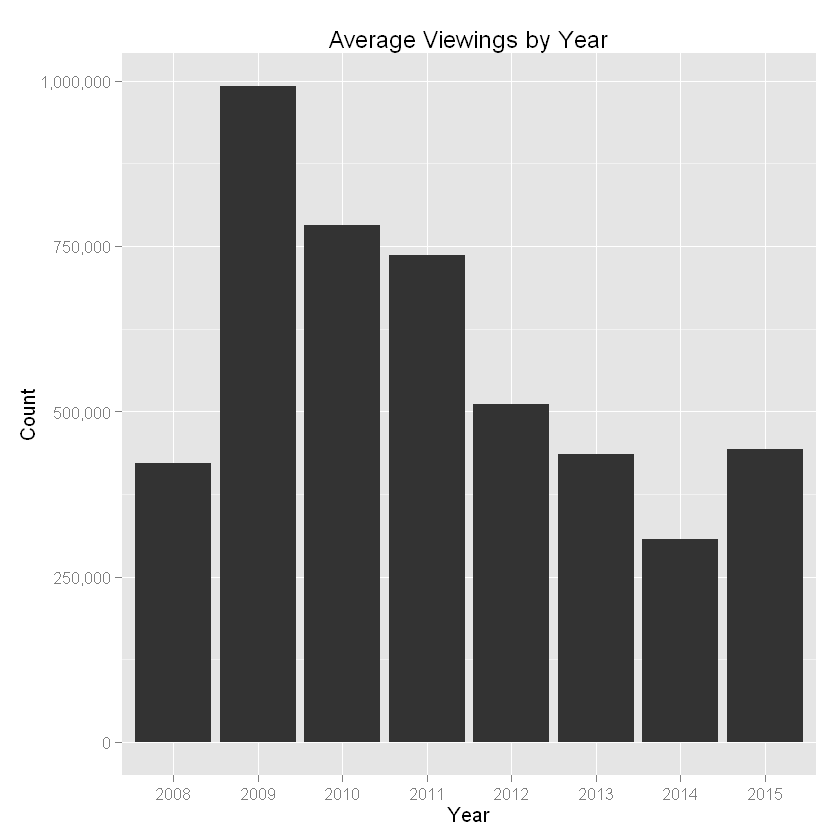

In [13]:
average_viewings_plot <- ggplot(data = viewings, aes(as.factor(year), ave_viewings)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Year', y = 'Count', title = 'Average Viewings by Year') +
  scale_y_continuous(labels = comma)
average_viewings_plot

These are also pretty big numbers. Ten thousand videos in 2009, and on average, each one was watch almost a million times. In fact, 2009 was a fairly weird year for Pornhub, as we'll see later.

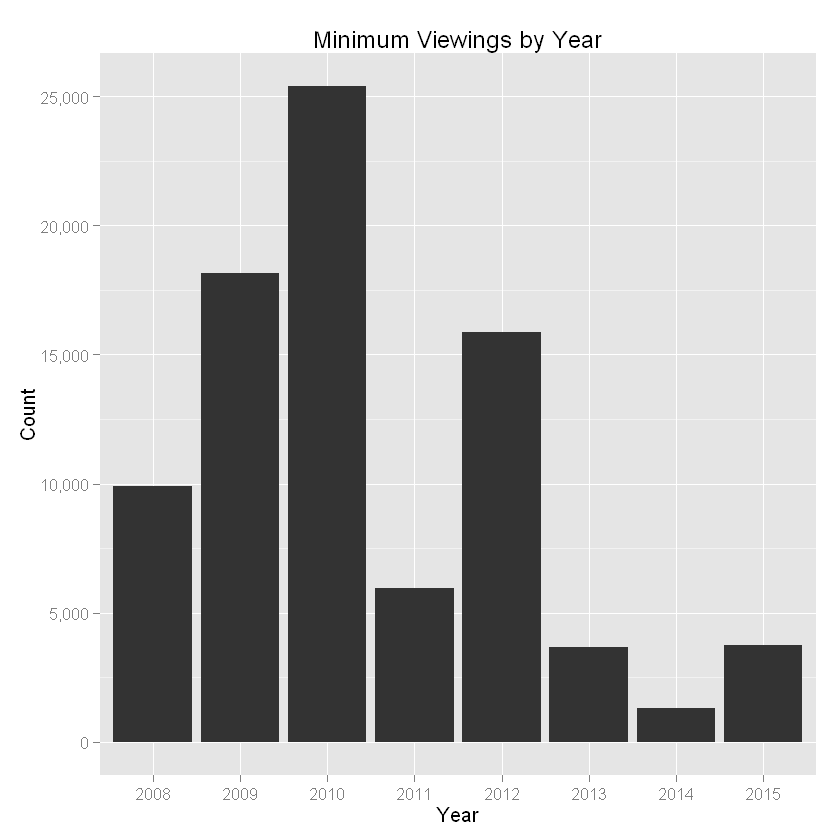

In [14]:
min_viewings_plot <- ggplot(data = viewings, aes(as.factor(year), min_viewings)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Year', y = 'Count', title = 'Minimum Viewings by Year') +
  scale_y_continuous(labels = comma)
min_viewings_plot

Here we have the number of views for the least watched video in each year. For 2010, the least watched video was seen over 25,000 times, which is a big change going to the next year, which is slightly over 5,000. The low is in 2014. This may be driven by a greater variety of videos. 2014 had the most added videos, but the least minimum.

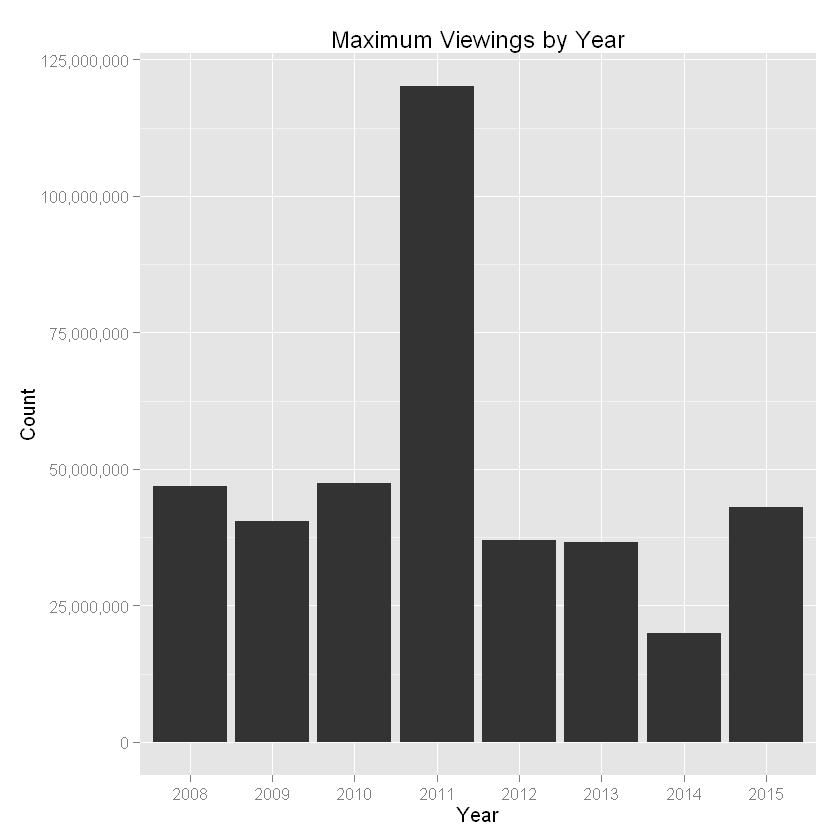

In [15]:
max_viewings_plot <- ggplot(data = viewings, aes(as.factor(year), max_viewings)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Year', y = 'Count', title = 'Maximum Viewings by Year') +
  scale_y_continuous(labels = comma)
max_viewings_plot

Maximum number of views: the range looks fairly small except for 2011. 2011 was the year the Kim Kardashian/Ray J sex tape hit Pornhub, at least from its legal distributor, Vivid, which is the video that we're seeing here.

Again, greater variety may be driving down the maximum views as well, but 2015's most popular video has more than double the views of 2014's most popular video, and the lowest overall.

It might be interesting to look at how much content there is in terms of time. `duration` lets us know how long each video was, but we were missing data, due to some errors in the scraping process. We should see how much data we're missing.

In [16]:
missing <- phub_2 %>% 
  filter(duration == '') %>% 
  nrow()

missing / nrow(phub_2)

[1] 0.03876238

A little less than 4% of videos are affected, which isn't too bad, but of course less than ideal.

For a quick pattern, we can see if some years are missing more than others.

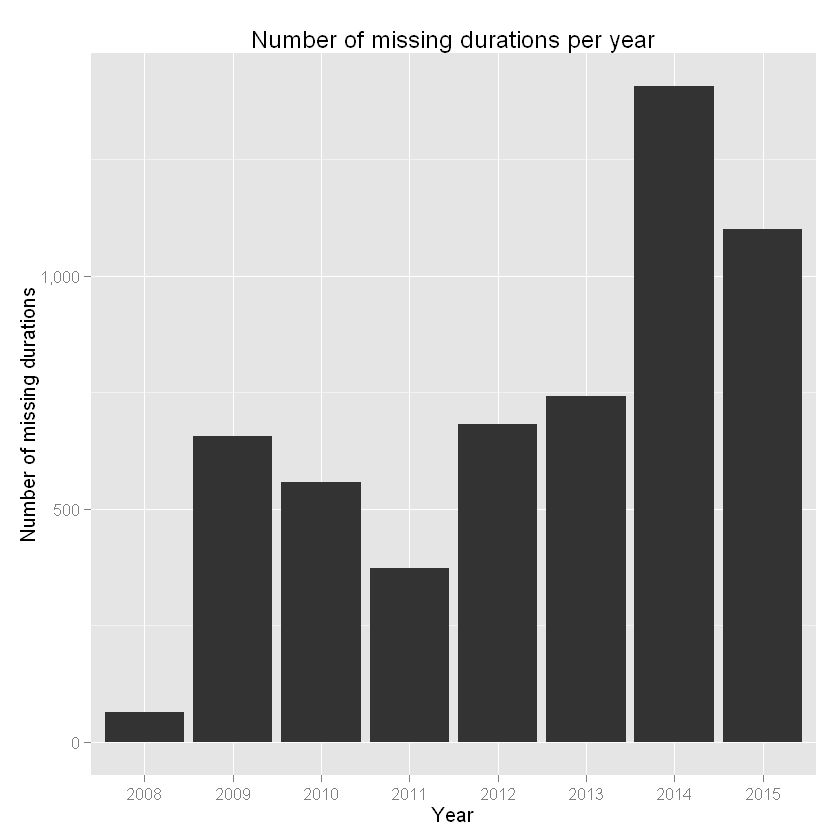

In [17]:
missing_durations <- phub_2 %>% 
  filter(duration == '')
missing_duration_plot <- ggplot(missing_durations, aes(as.factor(year))) +
  geom_bar() +
  labs(x = 'Year', y = 'Number of missing durations', title = 'Number of missing durations per year') +
  scale_y_continuous(labels = comma)
missing_duration_plot

If we compare it to the data above for number of videos per year, it's roughtly proportional for each year, except for 2008, which had relatively few missing years.

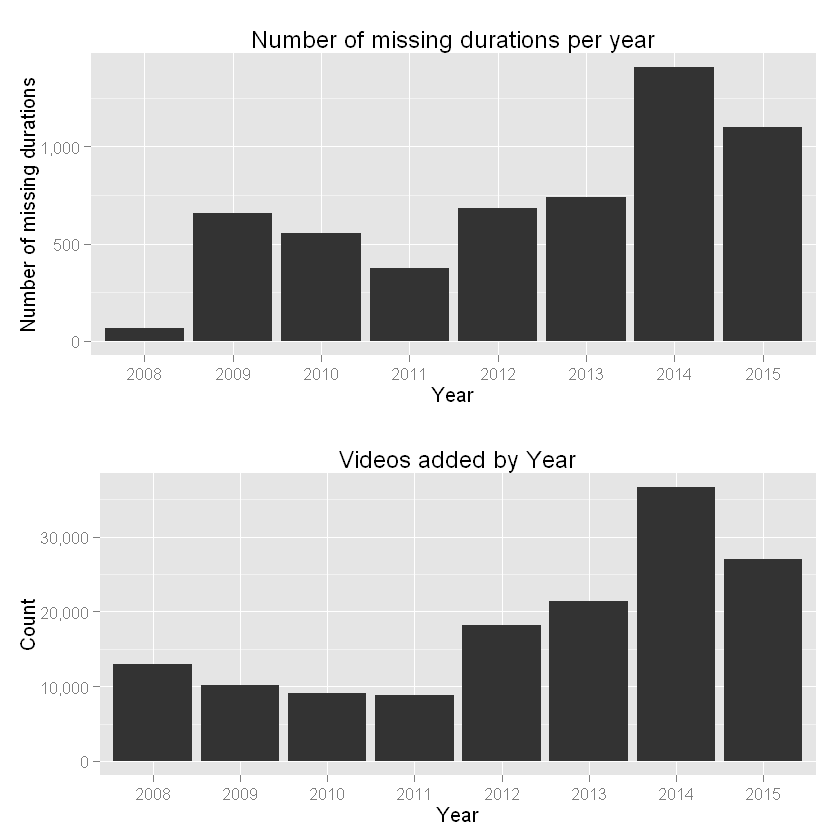

In [18]:
grid.arrange(missing_duration_plot, year_plot)

There may be a pattern to missing data, but it's most likely not by year.

We can continue to estimate our total time, but we'll have to impute the missing data to do so. We'll do a simple mean imputation, and see if we should do it by year (here we're going to ignore seconds for now and just look at minutes).

,year,m_minutes
1,2008,4.97019
2,2009,12.56464
3,2010,12.91137
4,2011,11.2702
5,2012,14.14257
6,2013,14.93841
7,2014,15.2543
8,2015,15.36098


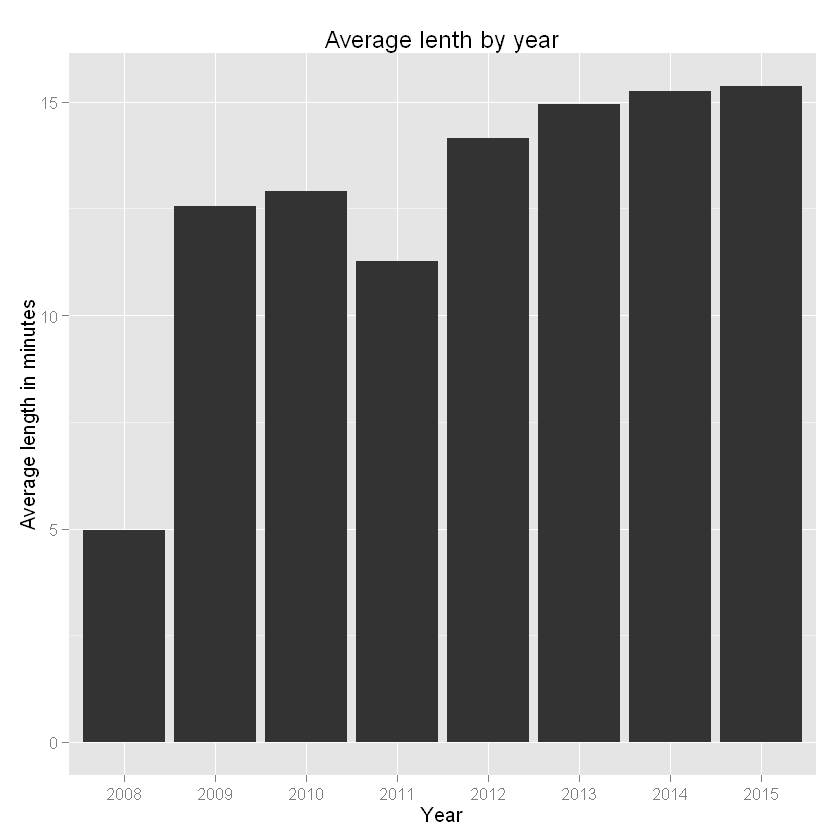

In [19]:
phub_durations <- phub_2 %>% 
  filter(duration != '')
phub_durations %<>%
  mutate(minutes = as.numeric(gsub("\\:\\d*$", "", duration))) %>% 
  group_by(year) %>% 
  summarise(m_minutes = mean(minutes))
phub_durations
quick_durations <- ggplot(phub_durations, aes(as.factor(year), m_minutes)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Year', y = 'Average length in minutes', title = 'Average lenth by year')
quick_durations

There does appear to be a difference in lengths, so we'll impute the missing data with the average length for the year.

In [20]:
seconds <- as.numeric(gsub("^\\d*\\:", "", phub_2$duration))
minutes <- as.numeric(gsub("\\:\\d*$", "", phub_2$duration))
phub_2$minutes <- (seconds + 60*minutes) / 60

phub_2 %>% 
  group_by(year) %>% 
  summarise(mean_length = mean(minutes, na.rm = T))

phub_2 %<>% 
  group_by(year) %>% 
  mutate(minutes = ifelse(is.na(minutes), mean(minutes, na.rm = T), minutes))

,year,mean_length
1,2008,5.360519
2,2009,13.01895
3,2010,13.3358
4,2011,11.64076
5,2012,14.53483
6,2013,15.34793
7,2014,15.67372
8,2015,15.79185


Each one is slightly longer because now we're including seconds into the calculation.

So how much total exists?

,year,total_length
1,2008,69220.38
2,2009,131504.4
3,2010,120422.3
4,2011,102194.2
5,2012,264795.6
6,2013,328092.7
7,2014,573814.7
8,2015,427248.6


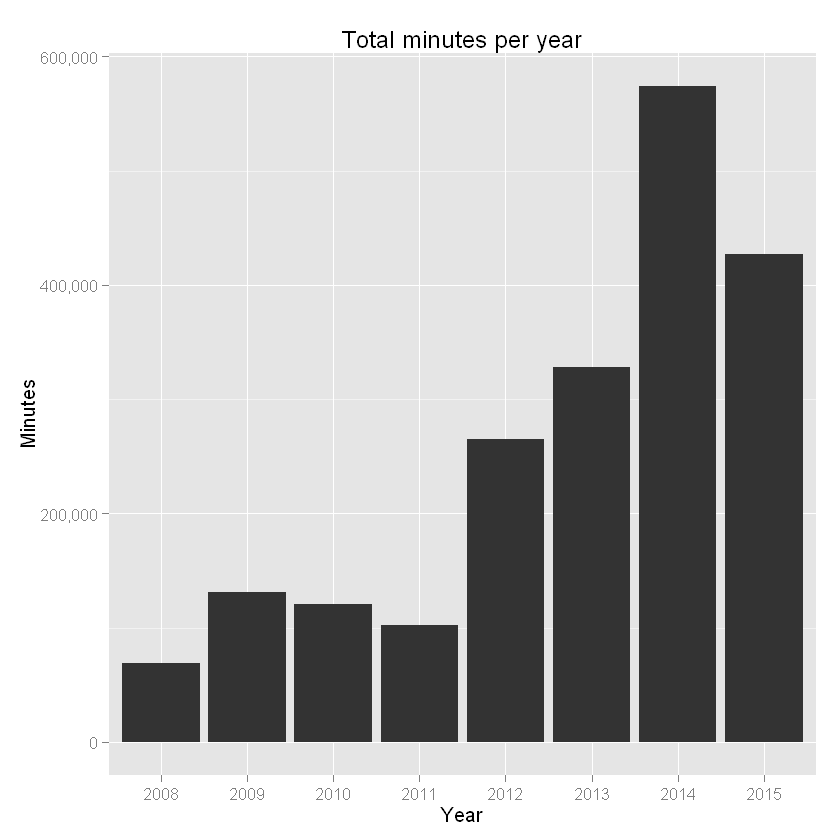

In [21]:
minutes_df <- phub_2 %>% 
  group_by(year) %>% 
  summarise(total_length = sum(minutes))
minutes_df

## in plot form:

minutes_plot <- ggplot(data = minutes_df, aes(as.factor(year), total_length)) +
  geom_bar(stat = 'identity') + 
  labs(x = 'Year', y = 'Minutes', title = 'Total minutes per year') +
  scale_y_continuous(labels = comma)
minutes_plot

Or in hours:

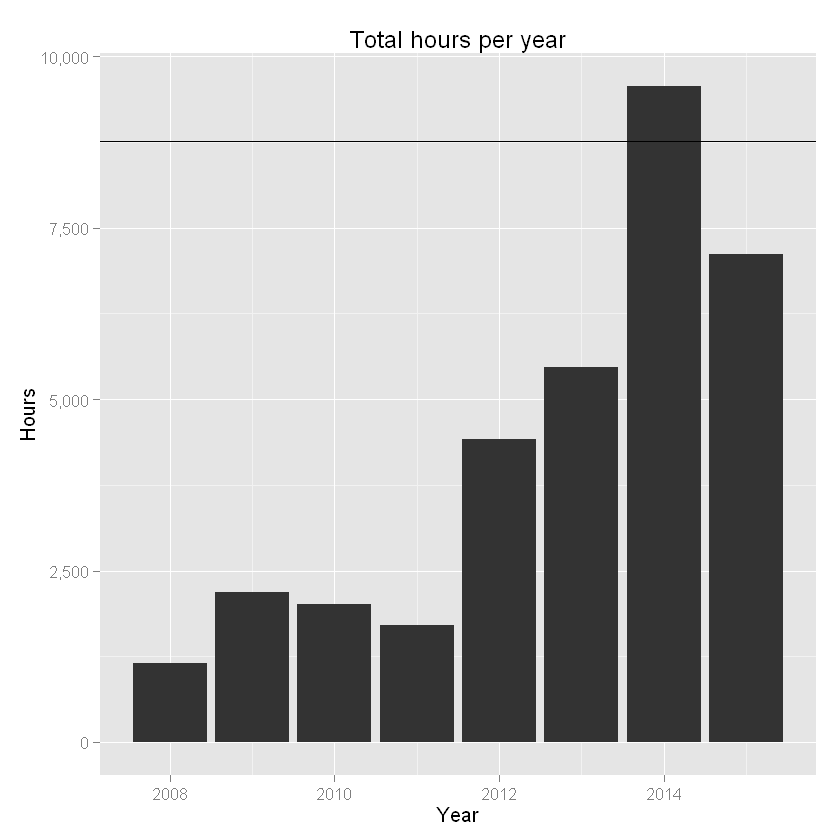

In [22]:
hours_df <- minutes_df %>% 
  mutate(hours = total_length/60)
hours_plot <- ggplot(data = hours_df, aes(year, hours)) +
  geom_bar(stat = 'identity') + 
  labs(x = 'Year', y = 'Hours', title = 'Total hours per year') +
  scale_y_continuous(labels = comma) + 
  geom_hline(yintercept=8766)
hours_plot

That's a lot of time. The reference line is the number of hours in a year, and 2014 cracked it (it looks like 2015 will soon).

If you had decided to watch every video added in 2014, it would take you more than a year to do so (about 416 days, to be precise).

Moving on, let's look at the most popular videos of all time.

In [23]:
top_all <- phub_2 %>% 
  ungroup() %>% 
  top_n(10, count) %>% 
  arrange(desc(count)) %>% 
  select(URL, year, title, count, pornstars, tags, categories)
top_all

,URL,year,title,count,pornstars,tags,categories
1,2006034279,2011,Kim Kardashian Sex Tape with Ray J,120070966,"Kim Kardashian, Ray J","celeb, big-tits, natural-tits, booty, bubble-butt, hollywood, celebrity, interracial, amateur, homemade, ass, babe, tight-pussy, black","Amateur, Big Ass, Celebrity, Blowjob, Interracial, Pornstar, Exclusive"
2,1418951301,2011,Incredibly passionate real sex scene,75953576,Mya Diamond,"hungarian, vivthomas.com, natural-tits, pornstar, brunette, big-tits, pussy-licking, hardcore, milf, kissing, cumshot","Babe, Brunette, Hardcore, Pornstar, For Women, Exclusive"
3,1472879328,2010,MILF Fucks Daughters Boyfriend,47472961,Jewels Jade,"mother, cougar, pornpros.com, amateur, homemade, milf, wife, mom, couple, lingerie, tattoo, brunette, blowjob, handjob, riding, cumshot, big-tits","Amateur, Big Tits, MILF, Pornstar"
4,6faafb57293e539bf5b5,2008,More than just a hot latin maid,46825690,Alexis Amore,"peruvian, fishnet, latina, piercing, mom, reality, blowjob, hardcore, maid, big-tits, pornstar, anal, riding, pov, doggystyle, tittyfuck, cumshot, ass","Latina, Pornstar, Anal, POV, Uniforms"
5,1005779365,2015,Mouth Cum Compilation - Part 3,43022725,Naughty Allie,"mouth-cum, compilation, blowjob, cumshots, facial, amateur, homemade","Amateur, Blowjob, Cumshots, Pornstar, Compilation"
6,72e859fea9f93e95051c,2009,Amazing Angel Dark takes big dick like a champ,40487946,"Angel Dark, Lex Steele","slovak, hardcore, bubble-butt, black, interracial, small-tits, brunette, outdoor, tight, teasing, pornstar, big-tits, pussy, rubbing, big-dick, blowjob, deepthroat, pov, doggystyle, cumshot","Big Dick, Big Tits, Interracial, Pornstar"
7,1641346385,2015,fucking hot,36986368,"Bruce Venture, Holly Michaels","bubble-butt, big-dick, busty, big-boobs, tattoo, ass, tight, body, pornstar, pussy-eating, deepthroat, female-friendly, tit-fucking, orgasm","Big Ass, Babe, Big Tits, Pornstar, HD"
8,1654607071,2012,Teen Latina Squirts while getting creampied,36938644,"Veronica Rodriguez, Voodoo","venezuelan, realitykings.com, cum, creampie, cream-pie, orgasm, squirting, young, teenager, massage, blowjob, big-dick, small-tits, skinny","Big Dick, Creampie, Latina, Pornstar, Teen, Squirt, Massage"
9,1366365249,2012,HomegrownVideos - Big Boobs Shione Cooper Rides Mark's Stiff Dick,36908934,Shione Cooper,"czech, homegrownvideo.com, natural-tits, big-tits, huge-tits, shaved, hardcore, facial, cumshots, cumshot, brunette, blowjob, titty-fucking, big-dick, big-boob, busty, boobs","Amateur, Big Tits, MILF, Pornstar"
10,109562043,2013,Teen Mom Farrah Abraham Sex Video,36565623,"Farrah Abraham, James Deen","brunette, farrah-abraham, big-dick, celebrity, young, celeb, sex-tape, long-legs, ass, backdoor","Brunette, Celebrity, Pornstar, Anal, Teen, Exclusive, HD"


Note that 2 of the videos on here, #1 and #10 feature celebrities, Kim Kardashian and Farrah Abraham, both reality show stars.

Kim Kardashian's was an amateur video leaked with then boyfriend Ray J, which helped to popularize her. The video was shot in 2003 and leaked online in 2007. Vivid released the video, and Kardashian sued, eventually selling the rights to Vivid for about 5 million dollars.

Farrah Abraham's video was filmed with James Deen, a popular porn star. Abraham initially claimed it was a leaked sex tape, although James Deen denied that claim, saying it was made with the intention of releasing it. Abraham eventually admitted hiring Deen to film it with the intention of selling it, and sold it to Vivid for 1.5 million dollars.

If we want a bigger list, we can break it up by year and see the most popular films for each year.

In [24]:
top_by_year <- phub_2 %>% 
  group_by(year) %>% 
  top_n(10, count) %>% 
  arrange(desc(count)) %>% 
  select(URL, title, count, pornstars, tags, categories)
top_by_year

,year,URL,title,count,pornstars,tags,categories
1,2008,6faafb57293e539bf5b5,More than just a hot latin maid,46825690,Alexis Amore,"peruvian, fishnet, latina, piercing, mom, reality, blowjob, hardcore, maid, big-tits, pornstar, anal, riding, pov, doggystyle, tittyfuck, cumshot, ass","Latina, Pornstar, Anal, POV, Uniforms"
2,2008,c8bfd6f2100eb4368c68,"Big tit MILF assfucked, double fucked and facialised!!",25792483,Tara Wild,"big-tits, fake-tits, blonde, blowjob, groupsex, wife, cum, cumshot, double-blowjob, double-penetration, pussy, pussylicking, ass, ass-licking, threesome","Big Tits, MILF, Pornstar, Anal, Threesome, Double Penetration"
3,2008,5d87055c333f07bca8e3,Hardcore teen lesbians orgy,22303442,"Amy Lee, Judy Star, Lara Roxx, Malezia, Sarah Moon, Shelby Belle, Sheryl Ann, Sweet Nicky","lesbian-orgy, gangbang, groupsex, dildo, toys, strap-on, hardcore, tight-pussy, teasing, pussylicking, fingering, masturbation, doggystyle, riding, teen, ass-licking","Orgy, Toys, Lesbian, Pornstar, Teen, Rough Sex, Gangbang"
4,2008,57a1f70f4f7a87ed3f6c,Tight horny blonde chick riding towards a warm creampie,22251814,,"blonde, blowjob, doggystyle, creampie, teen, tight, cum, cumshot, riding","Blonde, Creampie, Teen"
5,2008,99fe63f3e0041f02638a,Arab nice tits,19883965,,"arab, spy, voyeur, car, public, outdoor, amateur, homemade","Amateur, Public, Arab"
6,2008,e79ffee34b32da7456db,Blonde student fucked by random dude,19816720,Veronika Raquel,"natural-tits, blonde, masturbation, blowjob, hardcore, doggystyle, cumshot, facial, amateur, riding, reality, natural","Big Tits, Blonde, Hardcore, Pornstar"
7,2008,1288cb7fce6137da24cd,Hot pornstar Carmella Bing gets gangbanged hardcore,19077551,"Carmella Bing, James Deen, Marco Banderas","big-dick, huge-tits, pornstar, big-tits, busty, latin, latino, hardcore, groupsex, gangbang, blowjob, deepthroat, anal, double-penetration, double-vaginal, doggystyle, riding, cumshot, orgy","Bukkake, Pornstar, Rough Sex, Double Penetration, Gangbang"
8,2008,9dcf4e86a225fb4d0ca7,Most popular Eve Lawrence vid,19055359,"Eve Lawrence, Mark Ashley","big-dick, fake-tits, pornstar, brunette, big-tits, hardcore, face-fuck, deepthroat, blowjob, riding, doggystyle, facial, cumshot, striptease","Big Tits, Hardcore, Pornstar"
9,2008,2cfbc22310612dc423ce,Outstanding teen sex skills,16134956,"Lindsey Meadows, Manuel Ferrara","small-tits, brunette, panties, rubbing, babe, striptease, fingering, pussy, close-up, blowjob, big-dick, couch, riding, ass, doggystyle, hardcore, handjob","Brunette, Hardcore, Pornstar, Teen"
10,2008,abf7ae18a4f9d9a159b9,"Hardcore italian porn-big tit pornstars,anal.....",15862876,"Erika Bella, Julia Taylor","hungarian, ass, ass-licking, ass-to-mouth, babe, hardcore, big-tits, blonde, brunette, pornstar, groupsex, threesome, pussy, pussylicking, doggystyle, ana, orgy","Orgy, Big Tits, Pornstar, Threesome"


It's interesting that most of these films have stars listed, whereas in the whole set of video, the star field is often empty.

In [25]:
## Proportion in whole dataset with no star listed
sum(phub_2$pornstars == '')/ nrow(phub_2)

## Proportion in top by year dataset with no star listed
sum(top_by_year$pornstars == '') / nrow(top_by_year)


[1] 0.5763553

[1] 0.0875

57% of videos in the whole dataset have no performer listed, whereas in the top by year (so top 10 videos for each year), less than 9% of videos have no performer listed.

Does star status vary by year?

,year,No star,Star
1,2008,10222,2691
2,2009,5962,4139
3,2010,5225,3805
4,2011,4850,3929
5,2012,9758,8460
6,2013,10448,10929
7,2014,20675,15935
8,2015,15903,11152


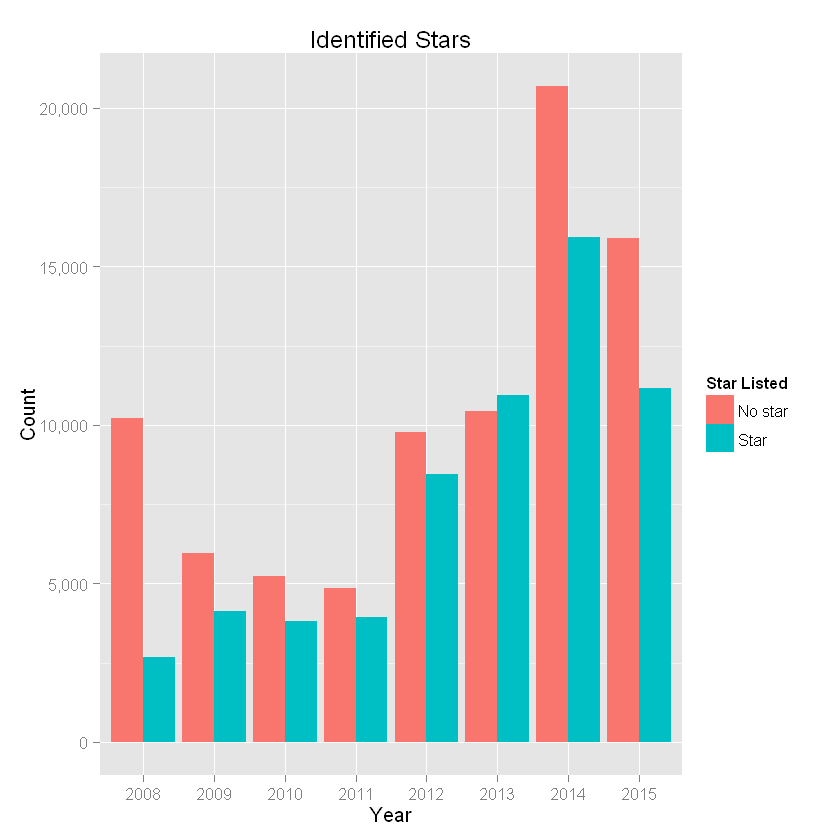

In [26]:
no_stars <- phub_2 %>% 
  mutate(pornstar_yn = ifelse(pornstars == '', 'No star', 'Star'))
no_stars %>%
  group_by(year, pornstar_yn) %>%
  summarise(count = n()) %>% 
  spread(key = pornstar_yn, value = count)
stars_plot <- ggplot(data = no_stars, aes(as.factor(year), fill = pornstar_yn)) +
  geom_bar(position = 'dodge') +
  labs(x = 'Year', y = 'Count', title = 'Identified Stars') +
  scale_y_continuous(labels = comma) +
  scale_fill_discrete(name = "Star Listed")
stars_plot

Generally speaking the majority of videos are missing star status, except for 2013.

Another feature available in the data is `submitter`, the person(s) who put the video onto Pornhub in the first place. How many are there?

In [27]:
phub_2 %>% 
  distinct(submitter) %>% 
  nrow()

[1] 15966

That's a sizeable amount of submitters. Who are the top submitters (based on count)? (The most common submitter is `Unknown`, so we'll actually filter that out; not sure why Pornhub would not have that data available; possibly deleted users?)

In [28]:
submitters <- phub_2 %>% 
  filter(submitter != 'Unknown') %>% 
  group_by(submitter) %>% 
  summarise(count = n()) %>% 
  top_n(20) %>% 
  arrange(desc(count))
submitters

Selecting by count


,submitter,count
1,Brazzers,1513
2,pornhub,1258
3,Pornstar Network,869
4,Mofos,849
5,Reality Kings,815
6,Telsev,776
7,maxima2308,709
8,Kemaco Studio,685
9,Lingerie Lover,639
10,Premium HDV,589


Brazzers has submitted over 1500 videos. Aside from Pornhub themselves, they have almost twice the number of submissions as the next most profific submitter.

So out of the top 20 submitters, what proportion of all videos did they submit?

In [29]:
no_submitters <- phub_2 %>% 
  filter(submitter %in% submitters$submitter) %>% 
  nrow()

no_submitters/nrow(phub_2)

[1] 0.09251612

About 10%, which isn't bad, considering they account for about 0.1% of all submitters.

It might be interesting to see if these submitters have particular tags they like, or stars. We'll explore that a little later.

First let's do some more analysis of stars.

We'll start off with a wordcloud of the most popular stars, because wordclouds, despite sometimes being referred to as the mullets of the internet, are fun.

We need to transform our data, and we'll dip into data.table for that.

In [30]:
phub_dt <- data.table(phub_2)
phub_stars_long <- phub_dt[ , list( pornstars = unlist( strsplit( pornstars , "," ) ) ) , 
                           by = c("URL", "year", "count", "submitter") ]

## further on a problem was discovered, that some stars have
## leading or trailing spaces, so we should clean them up
## a function will come in handy here

trim <- function (x) gsub("^\\s+|\\s+$", "", x)

phub_stars_long$pornstars <- trim(phub_stars_long$pornstars)

## There was also a weird formatting issue for one performer, April Oneill

phub_stars_long$pornstars <- gsub("\"", "", phub_stars_long$pornstars)

There will almost certainly be a time trend here, but we'll just look at the top all time stars, first by video count, and then by view count

,pornstars,raw_count,view_count
1,James Deen,515,550700154
2,Manuel Ferrara,449,549140642
3,Lisa Ann,400,542584986
4,Lex Steele,391,398421659
5,Asa Akira,370,336846783
6,Johnny Sins,358,424711580
7,Eva Angelina,333,261519741
8,Gianna Michaels,328,266194018
9,Jayden James,300,187239833
10,Tory Lane,289,246859847


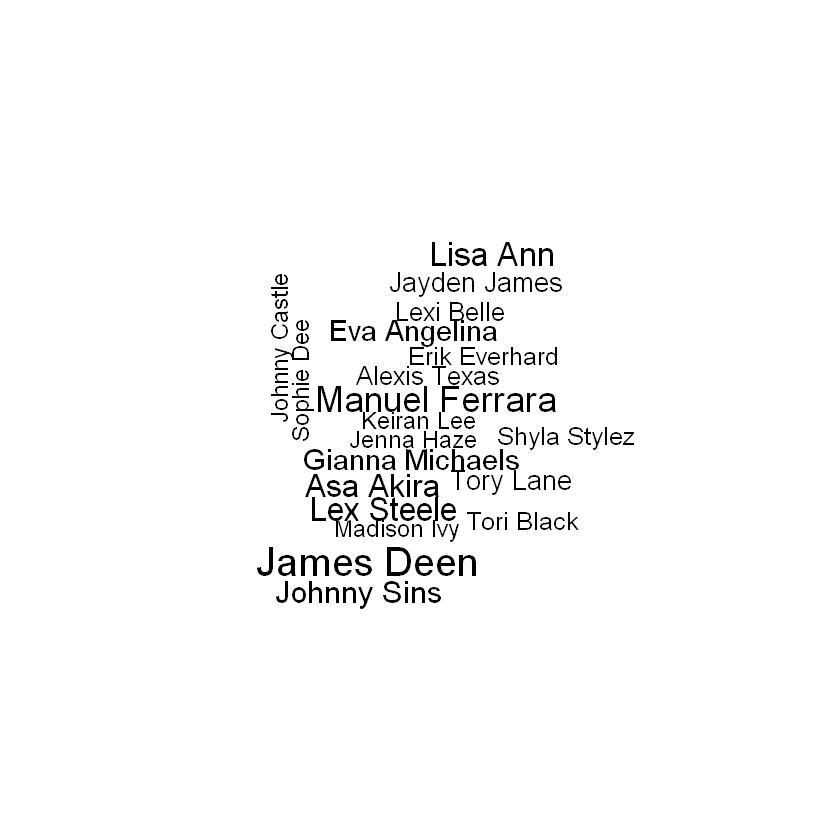

In [31]:
pornstar_df <- phub_stars_long %>%
  group_by(pornstars) %>% 
  summarise(raw_count = n(), view_count = sum(as.numeric(count))) %>% 
  arrange(desc(raw_count))               ## rank by raw video count

head(pornstar_df, 20)

pornstar_raw <- pornstar_df %>% 
  top_n(20, raw_count)
wordcloud(pornstar_raw$pornstars, pornstar_raw$raw_count, scale = c(2, .5))

And if we wanted to repeat with view count...

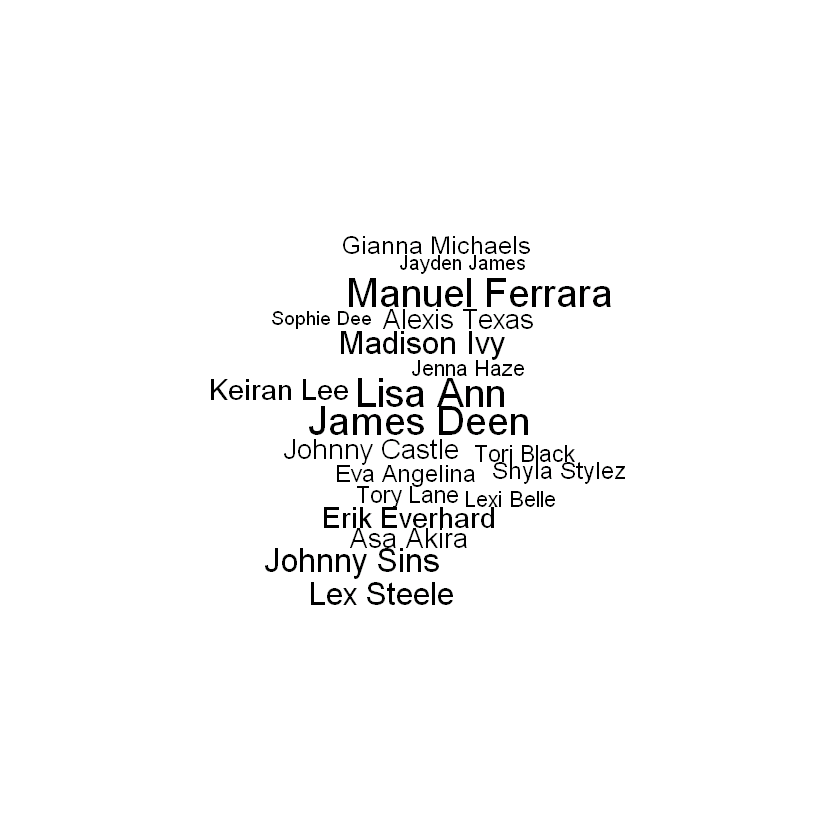

In [32]:
pornstar_views <- pornstar_df %>% 
  top_n(20, view_count)
wordcloud(pornstar_raw$pornstars, pornstar_raw$view_count, scale = c(2, .5))

Now we can consider the top submitters and see what stars they use often.

In [33]:
star_submitters <- phub_stars_long %>% 
  filter(submitter %in% submitters$submitter)
star_submitters_grouped <- star_submitters %>% 
  group_by(submitter, pornstars) %>% 
  summarise(count = n()) %>% 
  ungroup() %>% 
  arrange(desc(count))
head(star_submitters_grouped, 20)

,submitter,pornstars,count
1,Brazzers,Johnny Sins,230
2,Brazzers,Keiran Lee,211
3,Brazzers,Danny D,100
4,Brazzers,James Deen,55
5,Brazzers,Erik Everhard,43
6,Brazzers,Manuel Ferrara,37
7,Kemaco Studio,Leo Galvez,37
8,Brazzers,Bill Bailey,37
9,Brazzers,Phoenix Marie,33
10,Kemaco Studio,Jordanne Kali,30


Interestingly, men occupy the top 8 spots. Also, the top 6 spots are all from the same company, which may not be too surprising since they have released so many videos.

There will likely be a time trend. We can group the data by year and see how the years play out.

,pornstars,counts
1,James Deen,515
2,Manuel Ferrara,449
3,Lisa Ann,400
4,Lex Steele,391
5,Asa Akira,370
6,Johnny Sins,358
7,Eva Angelina,333
8,Gianna Michaels,328
9,Jayden James,300
10,Tory Lane,289


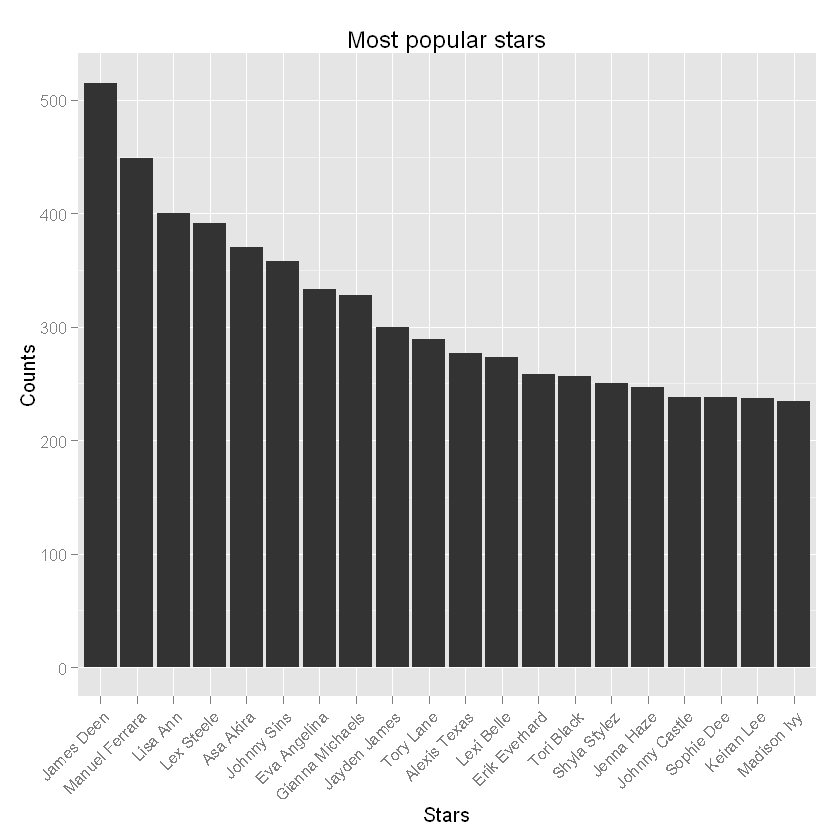

In [34]:
phub_stars_long <- data.frame(phub_stars_long)  ## data.table was behaving a little awkwardly, so we'll put it back
most_popular_stars <- phub_stars_long %>%       ## into a dataframe
  group_by(pornstars) %>% 
  summarise(counts = n()) %>% 
  arrange(desc(counts)) %>% 
  top_n(20, counts)
most_popular_stars

most_popular_stars_plot <- ggplot(most_popular_stars, aes(reorder(pornstars, -counts), counts)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Stars', y = 'Counts', title = 'Most popular stars') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
most_popular_stars_plot

Note here that while men are still in the top 2, there are more women towards the top compared to when we only considered the top submitters.

We can now examine the time aspect, looking at how many videos stars appeared in for a given year.

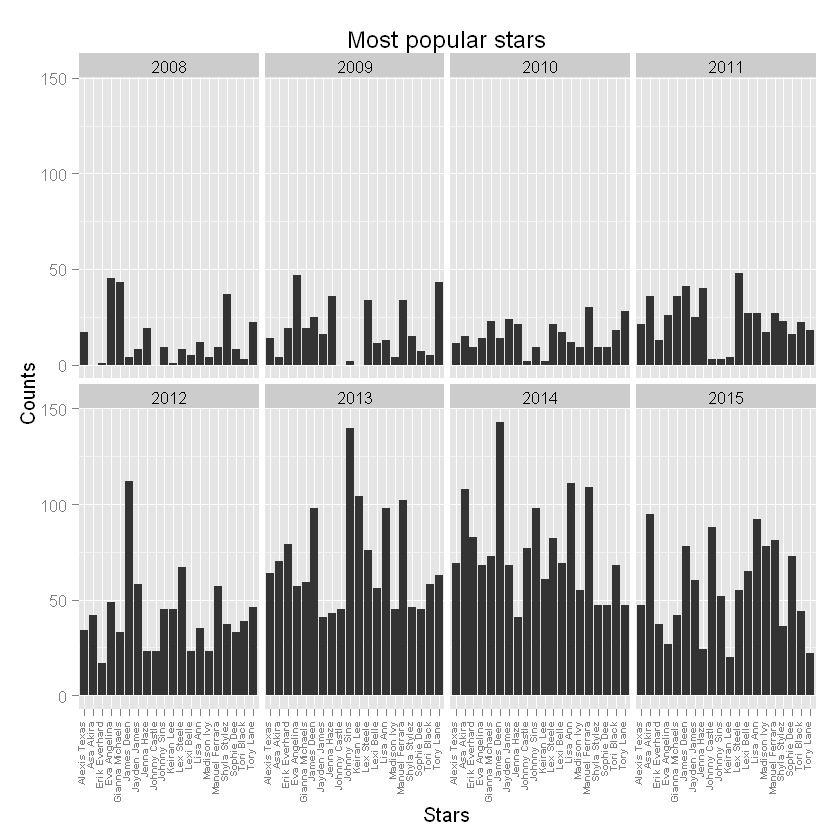

In [35]:
most_popular_stars_year <- phub_stars_long %>% 
  filter(pornstars %in% most_popular_stars$pornstars) %>% 
  group_by(year, pornstars) %>% 
  summarise(counts = n()) 

most_popular_stars_year_plot <- ggplot(most_popular_stars_year, aes(pornstars, counts)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Stars', y = 'Counts', title = 'Most popular stars') +
  theme(axis.text.x = element_text(size = 6, face = 'bold', angle = 90, hjust = 1, vjust = 0)) +
  facet_wrap(~year, nrow = 2)
most_popular_stars_year_plot

## Forgive the x axis being a little wonky, jupyter apparently doesn't render ggplot as well as RStudio

An alternative approach would be to just look at the top performers by year. To do this, we'll use a plotting function found here: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/

In [36]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)
  
  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)
  
  numPlots = length(plots)
  
  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                     ncol = cols, nrow = ceiling(numPlots/cols))
  }
  
  if (numPlots==1) {
    print(plots[[1]])
    
  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
    
    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
      
      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

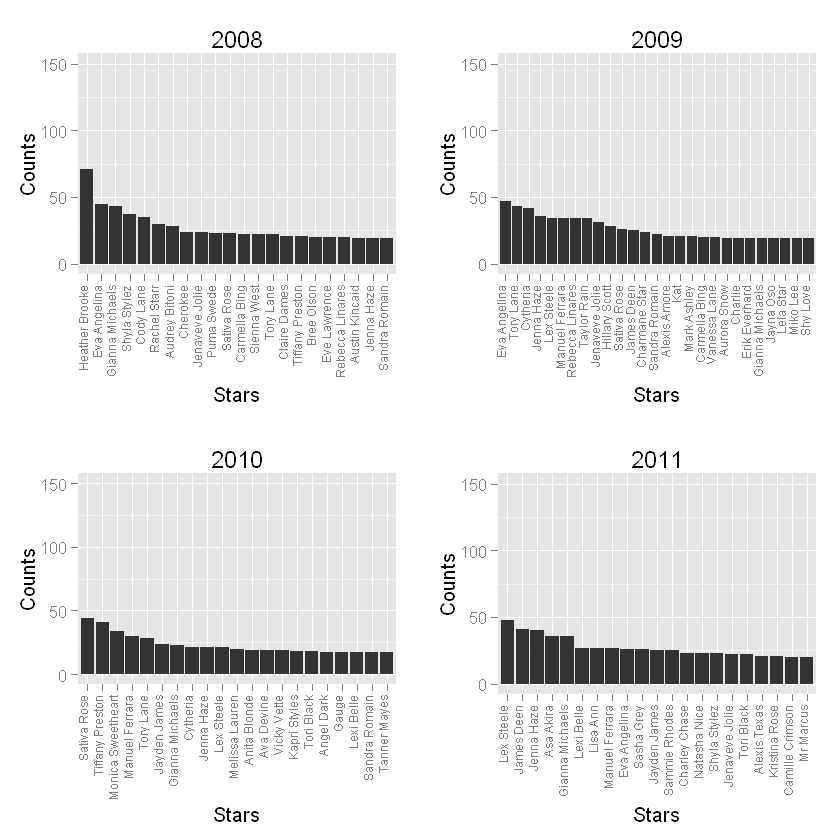

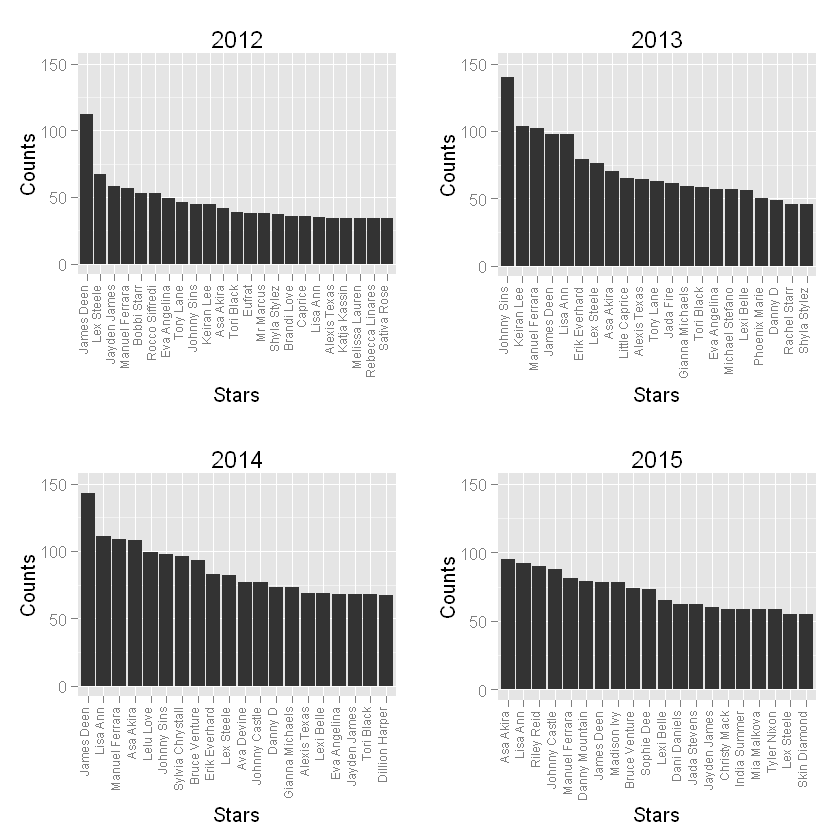

In [37]:
## Here we'll go through a loop here to set up the plot for each year

phub_stars_long <- data.table(phub_stars_long)     ## apparently dataframes don't like this code,
plot_list <- list()                                ## so back to data.table we go
for(year_i in 2008:2015){
  this_year <- phub_stars_long[phub_stars_long$year == year_i]
  this_year_proc <- this_year %>% 
    group_by(pornstars) %>% 
    summarise(counts = n()) %>% 
    top_n(20, counts)
  this_plot <- ggplot(this_year_proc, aes(reorder(pornstars, -counts), counts)) +
                        geom_bar(stat = 'identity') +
                        labs(x = 'Stars', y = 'Counts', title = year_i) +
                        theme(axis.text.x = element_text(size = 7, angle = 90, hjust = 1, vjust = 0)) +
                        scale_y_continuous(limits = c(0, 150))
  plot_list[[year_i - 2007]] <- this_plot
                      
}

## need to rearrange the plots so that the plots line up the way we like

plot_list_2_a <- list()
plot_list_2_a[[1]] <- plot_list[[1]]
plot_list_2_a[[3]] <- plot_list[[2]]
plot_list_2_a[[2]] <- plot_list[[3]]
plot_list_2_a[[4]] <- plot_list[[4]]
plot_list_2_b <- list()
plot_list_2_b[[1]] <- plot_list[[5]]
plot_list_2_b[[3]] <- plot_list[[6]]
plot_list_2_b[[2]] <- plot_list[[7]]
plot_list_2_b[[4]] <- plot_list[[8]]

multiplot(plotlist = plot_list_2_a, cols = 2)
multiplot(plotlist = plot_list_2_b, cols = 2)

There were some ties in counts, so some charts have more than 20 stars.

Early in Pornhubs career, women tended to dominate, but men became more popular. From 2011 to 2012, men had the top spot, with James Deen taking the top spot in 2 non-consecutive years, making him the Grover Cleveland of Pornhub.

We can repeat this graph, instead using view count instead of video count.

To maintain consistency, they will all be plot on the same scale.

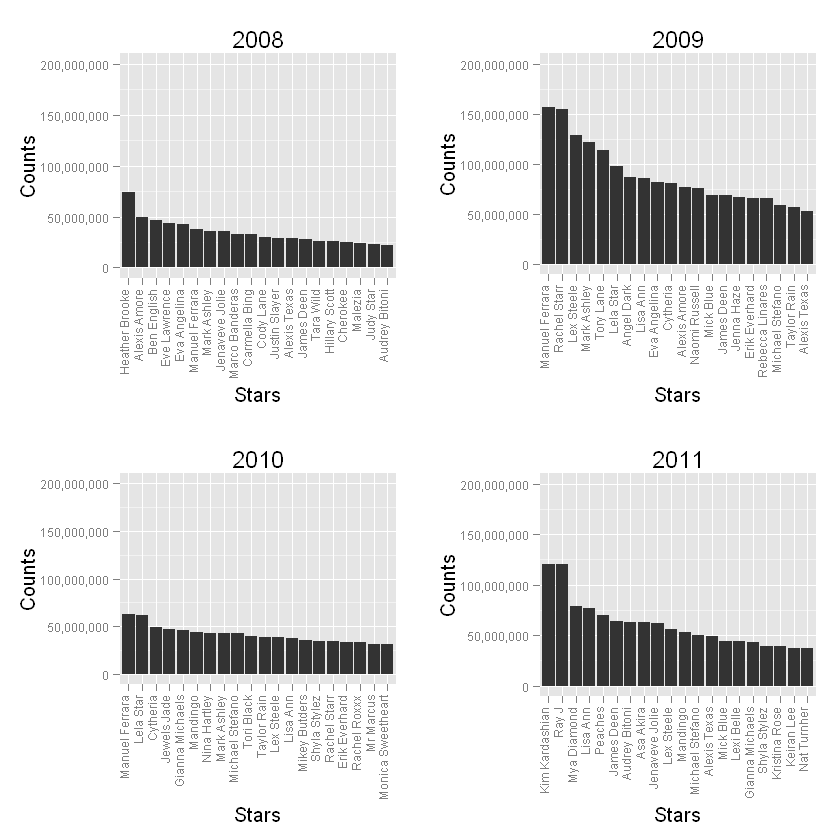

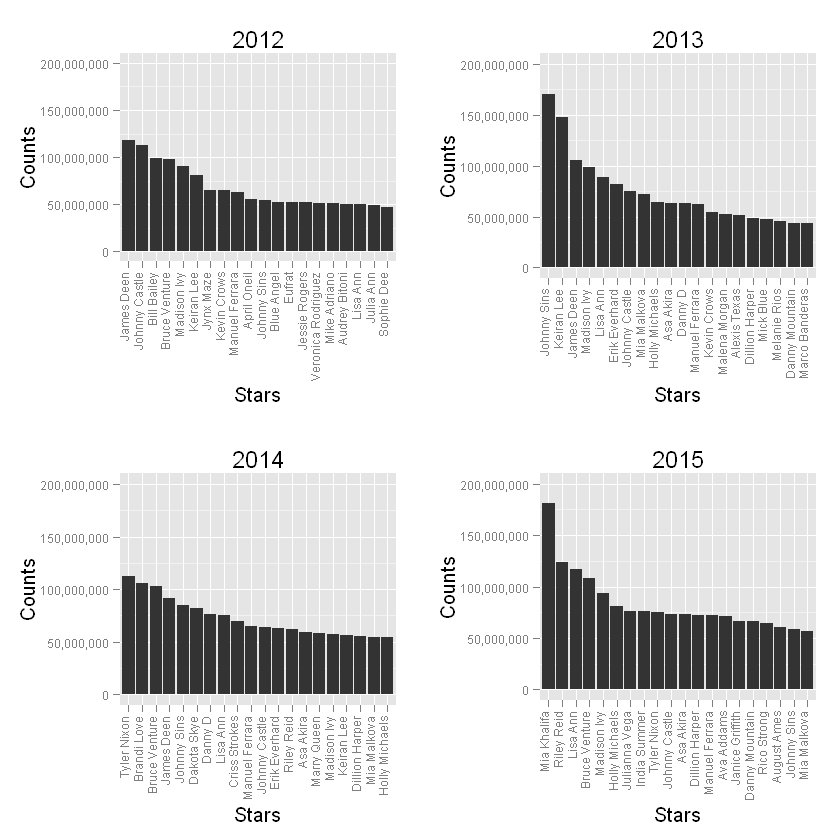

In [38]:

plot_list <- list()
for(year_i in 2008:2015){
  this_year <- phub_stars_long[phub_stars_long$year == year_i]
  this_year_proc <- this_year %>% 
    group_by(pornstars) %>% 
    summarise(counts = sum(as.numeric(count))) %>% 
    top_n(20, counts)
  this_plot <- ggplot(this_year_proc, aes(reorder(pornstars, -counts), counts)) +
    geom_bar(stat = 'identity') +
    labs(x = 'Stars', y = 'Counts', title = year_i) +
    theme(axis.text.x = element_text(size = 7, angle = 90, hjust = 1, vjust = 0),
          axis.text.y = element_text(size = 7)) +
    scale_y_continuous(labels = comma, limits = c(0, 200000000))
  plot_list[[year_i - 2007]] <- this_plot
  
}

## need to rearrange the plots

plot_list_2_a <- list()
plot_list_2_a[[1]] <- plot_list[[1]]
plot_list_2_a[[3]] <- plot_list[[2]]
plot_list_2_a[[2]] <- plot_list[[3]]
plot_list_2_a[[4]] <- plot_list[[4]]
plot_list_2_b <- list()
plot_list_2_b[[1]] <- plot_list[[5]]
plot_list_2_b[[3]] <- plot_list[[6]]
plot_list_2_b[[2]] <- plot_list[[7]]
plot_list_2_b[[4]] <- plot_list[[8]]

multiplot(plotlist = plot_list_2_a, cols = 2)
multiplot(plotlist = plot_list_2_b, cols = 2)

There are some standouts here. In 2008, Heather Brooks did fairly well compared to her colleagues.

In 2011, Kim Kardashian and Ray J did very well for themselves.

In 2013, Johnny Sins and Kieran Lee did very well.

And in 2015, Mia Khalifa did very well.

Something we haven't considered yet, how many unique performers are there?

In [47]:
length(unique(phub_stars_long$pornstar))

## or by year

unique_stars_year <- data.frame(phub_stars_long) %>%    ## more confusion with data.table/dplyr verbs
  group_by(year) %>% 
  distinct(pornstars) %>% 
  summarise(counts = n()) %>% 
  arrange(year)
unique_stars_year

[1] 6652

,year,counts
1,2008,985
2,2009,1655
3,2010,1814
4,2011,1728
5,2012,2870
6,2013,3329
7,2014,3953
8,2015,3287


Or in graph form:

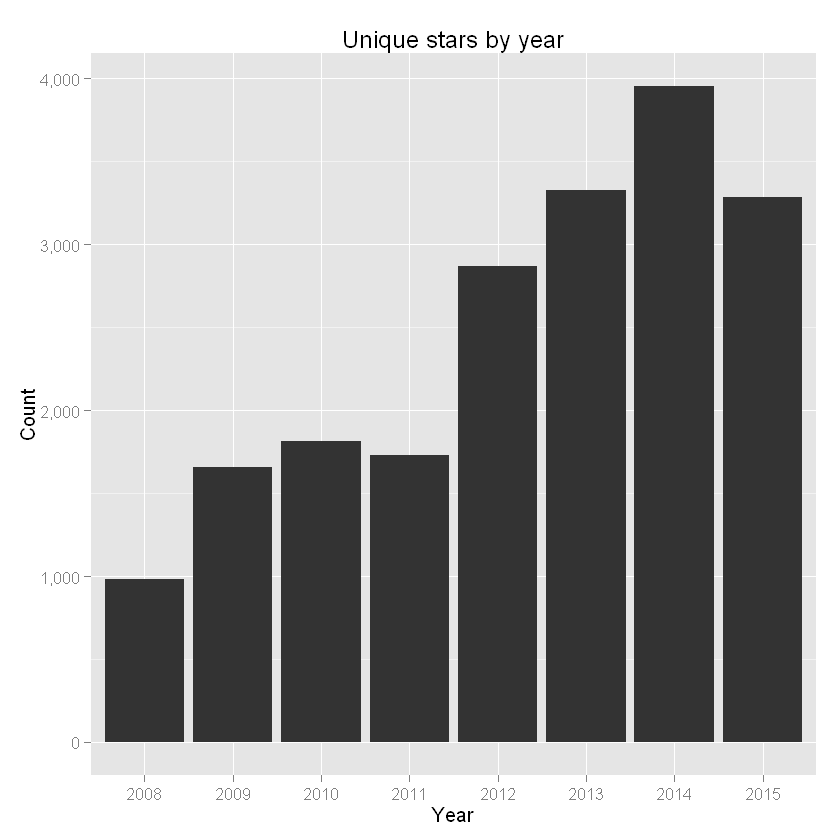

In [48]:
unique_stars_year_plot <- ggplot(unique_stars_year, aes(as.factor(year), counts)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Year', y = 'Count', title = 'Unique stars by year') +
  scale_y_continuous(labels = comma)
unique_stars_year_plot

Not too surprising, more videos means more variety. And as bandwidth increases, more companies are using the internet as a distribution model, which more easily leads to being distributed on the internet. In addition, the rise of the 'cam girl' may be driving this as well, as it's both easier for women to become cam girls, and easier to record sessions as a viewer. 

Moving on, we can do the same kind of analysis on tags. 

We'll need to reorganize the data, the way we did with stars, so that now a video can have multiple rows, one for each tag.

In [51]:
phub_tag_long <- phub_dt[ , list( tags = unlist( strsplit( tags , "," ) ) ) , 
                         by = c("URL", "year", 'submitter', 'count', 'votes_up', 'votes_down') ]
phub_tag_long$tags <- trim(phub_tag_long$tags)
nrow(phub_tag_long)

[1] 1886495

Almost 2 million rows of data now.

Before we look at the tags themselves, let's consider the variance, the number of unique tags per year.

,year,unique_tags
1,2008,3831
2,2009,634
3,2010,2177
4,2011,2541
5,2012,5572
6,2013,7067
7,2014,14346
8,2015,18317


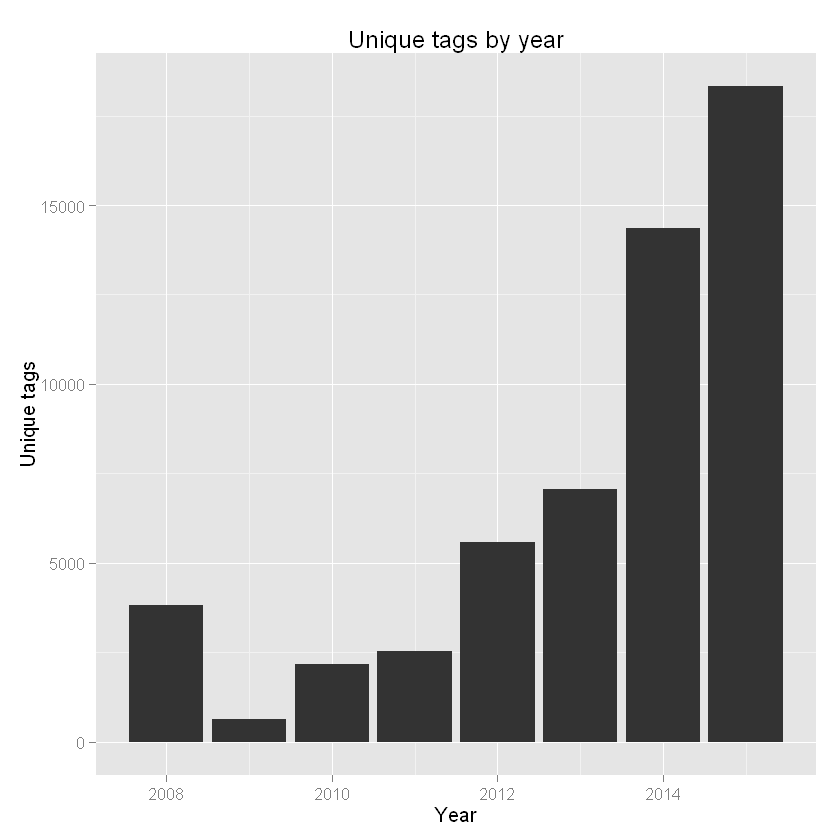

In [54]:
phub_tag_long <- data.frame(phub_tag_long)
tag_var <- phub_tag_long %>% 
  group_by(year) %>% 
  summarise(unique_tags = n_distinct(tags)) %>% 
  arrange(year)
tag_var

## or in graph form

tag_var_plot <- ggplot(tag_var, aes(year, unique_tags)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Year', y = 'Unique tags', title = 'Unique tags by year')
tag_var_plot

I'm not surprised at all that the number of tags would increase on a yearly basis, but I am pretty surprised that 2009 has such a low variety, a third of the next lowest, and about a sixth of the first year.

We can look at the tags from 2010 and see what tags are in that set that weren't in 2009.

In [56]:
tags_2010_df <- phub_tag_long %>% 
  filter(year == 2010) %>% 
  group_by(tags) %>% 
  summarise(count = n()) %>% 
  arrange(desc(count))

tags_2009_df <- phub_tag_long %>% 
  filter(year == 2009) %>% 
  group_by(tags) %>% 
  summarise(count = n()) %>% 
  arrange(desc(count))

tags_difference <- tags_2010_df %>% 
  anti_join(tags_2009_df, by = 'tags') %>% 
  arrange(desc(count))
tags_difference

,tags,count
1,vibrator,84
2,masturbate,71
3,booty,46
4,mmf,39
5,old,39
6,big-boobs,38
7,pornstars,38
8,lingerie-videos.com,37
9,humiliated.com,36
10,sucking,35


These tags are relatively rare in the 2010 subset (the most popular tag here had 84 hits, out of around 10,000 videos. By comparison, if we look at the top 10 tags for 2010, we have:

In [58]:
tags_2010_df %>% 
  top_n(10, count)

,tags,count
1,blowjob,4773
2,brunette,4118
3,big-tits,3376
4,handjob,3182
5,cumshot,3127
6,doggystyle,2937
7,pornstar,2739
8,tight,2509
9,blonde,2442
10,riding,2424


Obviously significantly greater numbers. But relatively few tags make up most of the videos; once we get to tag rank 131, every popular tag after that appears in 100 videos or less.

We'll leave the question of why 2009 has such low tag variety. If anyone has any ideas as to why this would be, I'd love to hear about it. They seem to have the popular ones. A further investigation not shown here also revealed that the tags in 2009 were simpler, e.g. the tag 'teen' was included in 2009, but not 'teens', 'teenager', 'teenagers', whereas 2010 did have those terms (although they were relatively rare compared to 'teen'), which may be driving part of the difference, but probably wouldn't account for all of it.

We'll move on now and look at the most popular tags, starting with all time.

,tags,count
1,blowjob,59131
2,brunette,44689
3,big-tits,41930
4,cumshot,41238
5,blonde,34114
6,hardcore,32614
7,natural-tits,27741
8,amateur,26680
9,facial,24218
10,homemade,23281


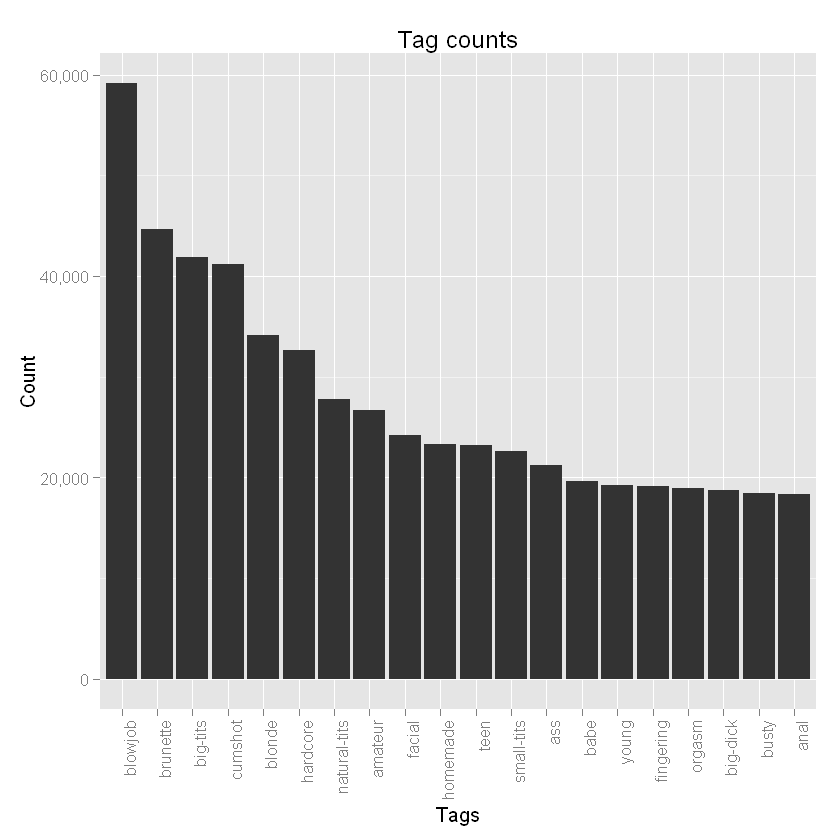

In [61]:
tag_counts <- phub_tag_long %>% 
  group_by(tags) %>% 
  summarise(count = n()) %>% 
  arrange(desc(count)) %>% 
  top_n(20, count)
tag_counts

## or in graph form:

tag_plot <- ggplot(tag_counts, aes(reorder(tags, -count), count)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Tags', y = 'Count', title = "Tag counts") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  scale_y_continuous(labels = comma)
tag_plot

So just a quick reminder on how to interpret this data: a video has one or more tags, and then in the transformation process, we spread those out over multiple rows. So a single video with two tags, 'blowjob' and 'brunette', will contribute to both of the bars above. Then we can say, there are almost 60,000 videos (out of around 144,000) that have 'blowjob' in its tags.

While this is interesting, it may be interesting to see how these popular tags have varied over the years.

,year,tags,count
1,2008,blowjob,4708
2,2008,hardcore,4506
3,2008,big-tits,3197
4,2008,brunette,3023
5,2008,blonde,2919
6,2008,cumshot,2710
7,2008,amateur,2237
8,2008,anal,1588
9,2008,ass,1562
10,2008,facial,1483


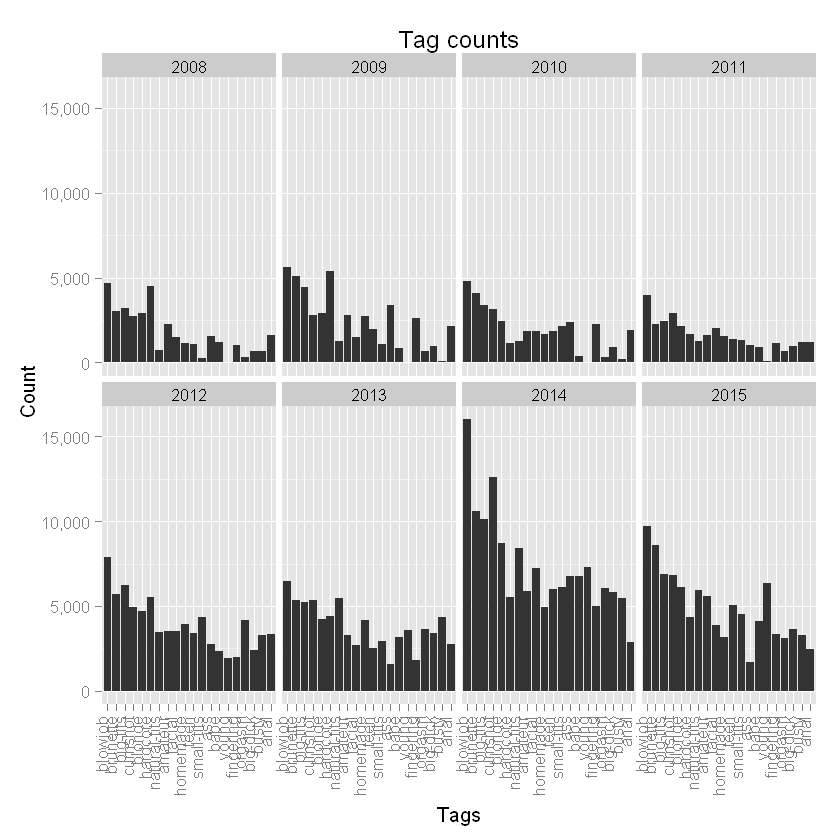

In [62]:
popular_tags <- tag_counts$tags
tag_counts_year <- phub_tag_long %>%
  filter(tags %in% popular_tags) %>% 
  group_by(year, tags) %>% 
  summarise(count = n()) %>% 
  arrange(desc(count))
tag_counts_year

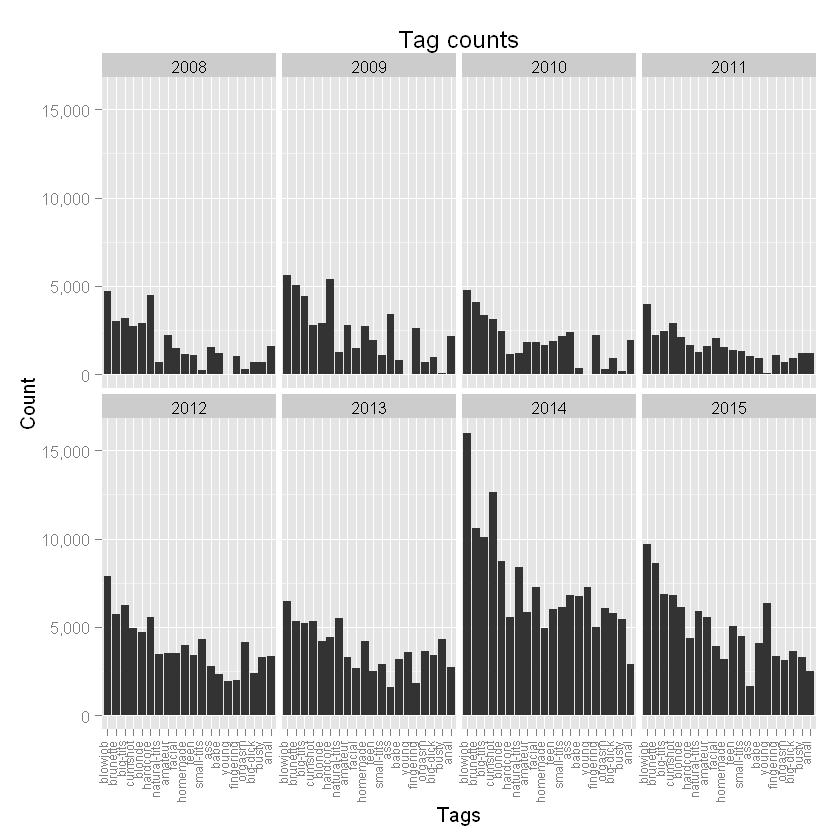

In [63]:
tag_plot_year <- ggplot(tag_counts_year, aes(reorder(tags, -count), count)) +
  geom_bar(stat = 'identity') +
  facet_wrap(~year, nrow = 2) +
  labs(x = 'Tags', y = 'Count', title = "Tag counts") +
  theme(axis.text.x = element_text(size = 7, angle = 90, hjust = 1, vjust = 0)) +
  scale_y_continuous(labels = comma)
tag_plot_year

It looks like it's been largely constant, but there are some interesting things. While `young` has been pretty popular, it didn't appear in a sizeable amount in 2008, 2009, 2010, or 2011. It did pick up steam after that. And `hardcore` rivaled `blowjob` in 2008 and 2009, but `blowjob` took the strong lead pretty quickly. `busty` didn't seem to be that popular in earlier years as well.

Let's repeat the above, but use view counts instead of unique videos.

Selecting by counts


,tags,counts
1,blowjob,33310047722
2,big-tits,26082937201
3,brunette,25119299922
4,cumshot,21751833029
5,hardcore,18378230239
6,blonde,17467764780
7,natural-tits,15135930159
8,big-dick,13224296130
9,teen,12951562847
10,amateur,12934061484


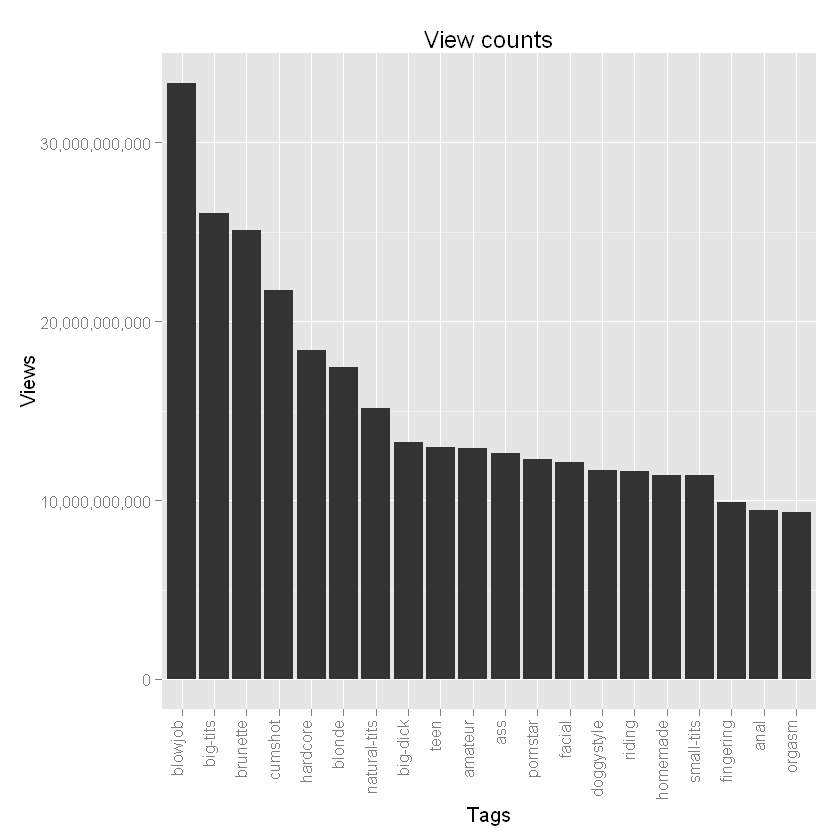

In [64]:
view_counts <- phub_tag_long %>% 
  group_by(tags) %>% 
  summarise(counts = sum(as.numeric(count))) %>% 
  arrange(desc(counts)) %>% 
  top_n(20)
view_counts

## or in graph form:

view_plot <- ggplot(view_counts, aes(reorder(tags, -counts), counts)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Tags', y = 'Views', title = "View counts") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0)) +
  scale_y_continuous(labels = comma)
view_plot

Mostly the same, which is not too surprising. The numbers are impressive, however; blowjob videos have been watched over 33,000,000,000 times. There's about 7,000,000,000 people on Earth. If you were to divide up blowjob videos equally to everyone on Earth, they could each have about 4 videos apiece.